In [1]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from skimage.metrics import structural_similarity as ssim
from sklearn.model_selection import train_test_split

def display_sample_patches(signal_patches, nonsignal_patches, num_samples=5):
    plt.figure(figsize=(15, 6))

    # Plot a few signal patches
    for i in range(num_samples):
        plt.subplot(2, num_samples, i + 1)
        plt.imshow(signal_patches[i], cmap='gray')
        plt.title(f'Signal {i + 1}')
        plt.axis('off')

    # Plot a few non-signal patches
    for i in range(num_samples):
        plt.subplot(2, num_samples, num_samples + i + 1)
        plt.imshow(nonsignal_patches[i], cmap='gray')
        plt.title(f'Non-Signal {i + 1}')
        plt.axis('off')

    plt.suptitle(f'Sample Image Patches (Signal vs Non-Signal)', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

def train_HO(X, y):
    v_present = X[y == 1]
    v_absent = X[y == 0]
    mean_present = np.mean(v_present, axis=0)
    mean_absent = np.mean(v_absent, axis=0)
    delta_mean = mean_present - mean_absent
    K1 = np.cov(v_absent, rowvar=False)
    K2 = np.cov(v_present, rowvar=False)
    K_avg = 0.5 * (K1 + K2)
    return np.linalg.pinv(K_avg) @ delta_mean

def apply_HO(X, w):
    return X @ w

def compute_SNR_squared(t_score, y):
    t_present = t_score[y == 1]
    t_absent = t_score[y == 0]
    mu1 = np.mean(t_present)
    mu0 = np.mean(t_absent)
    var1 = np.var(t_present, ddof=1)
    var0 = np.var(t_absent, ddof=1)
    sigma2 = 0.5 * (var1 + var0)
    return (mu1 - mu0)**2 / sigma2

def compute_decision_threshold(t_scores, y_labels):
    t_present = t_scores[y_labels == 1]
    t_absent = t_scores[y_labels == 0]
    mu1 = np.mean(t_present)
    mu0 = np.mean(t_absent)
    return 0.5 * (mu1 + mu0)

def generate_gabor_U(size=64, sigmas=[(4, 2)], thetas=[0, 30, 60, 90], freqs=[0.1, 0.15]):
    def create_gabor_channel(size, sigma_x, sigma_y, theta, freq):
        x = np.linspace(-size//2, size//2, size)
        y = np.linspace(-size//2, size//2, size)
        X, Y = np.meshgrid(x, y)
        theta_rad = np.deg2rad(theta)
        X_theta = X * np.cos(theta_rad) + Y * np.sin(theta_rad)
        Y_theta = -X * np.sin(theta_rad) + Y * np.cos(theta_rad)
        gb = np.exp(-0.5 * (X_theta**2 / sigma_x**2 + Y_theta**2 / sigma_y**2)) * np.cos(2 * np.pi * freq * X_theta)
        return gb
    channels = []
    for sigma_x, sigma_y in sigmas:
        for theta in thetas:
            for freq in freqs:
                gabor = create_gabor_channel(size=size, sigma_x=sigma_x, sigma_y=sigma_y, theta=theta, freq=freq)
                channels.append(gabor)
    channels = np.stack(channels)
    U = channels.reshape(channels.shape[0], -1).T
    return U


=== Showing results for: patches_amp_0.05_noise_0.0001_accel_2.npy ===


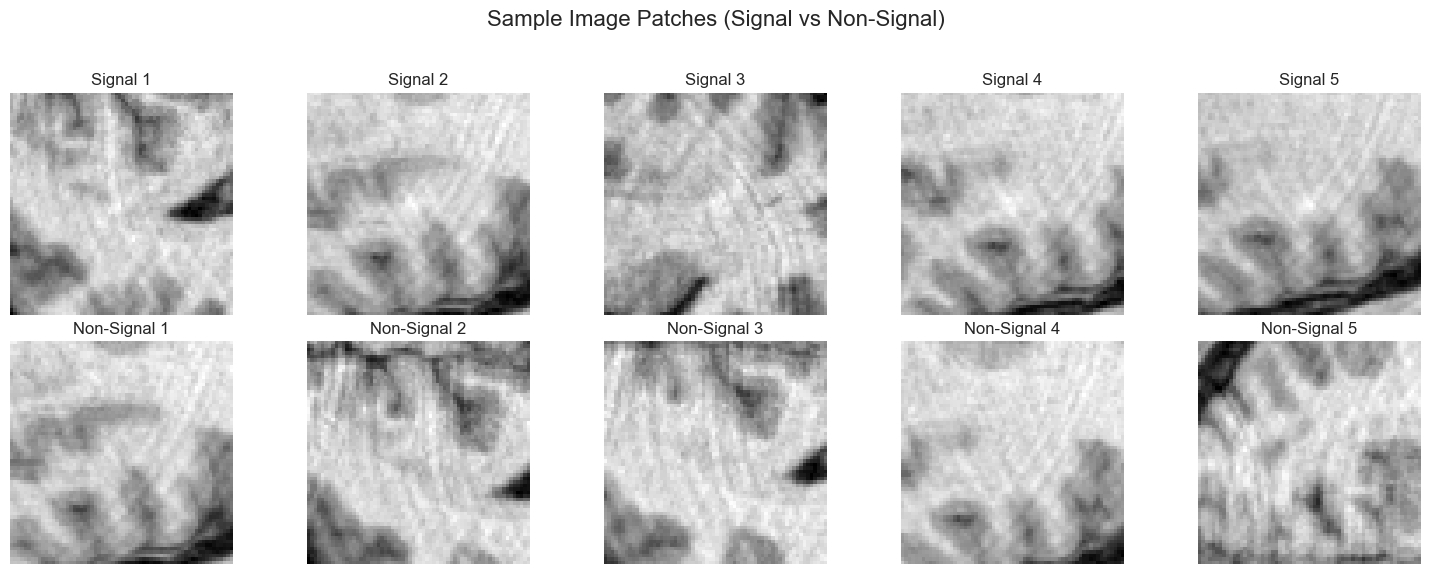

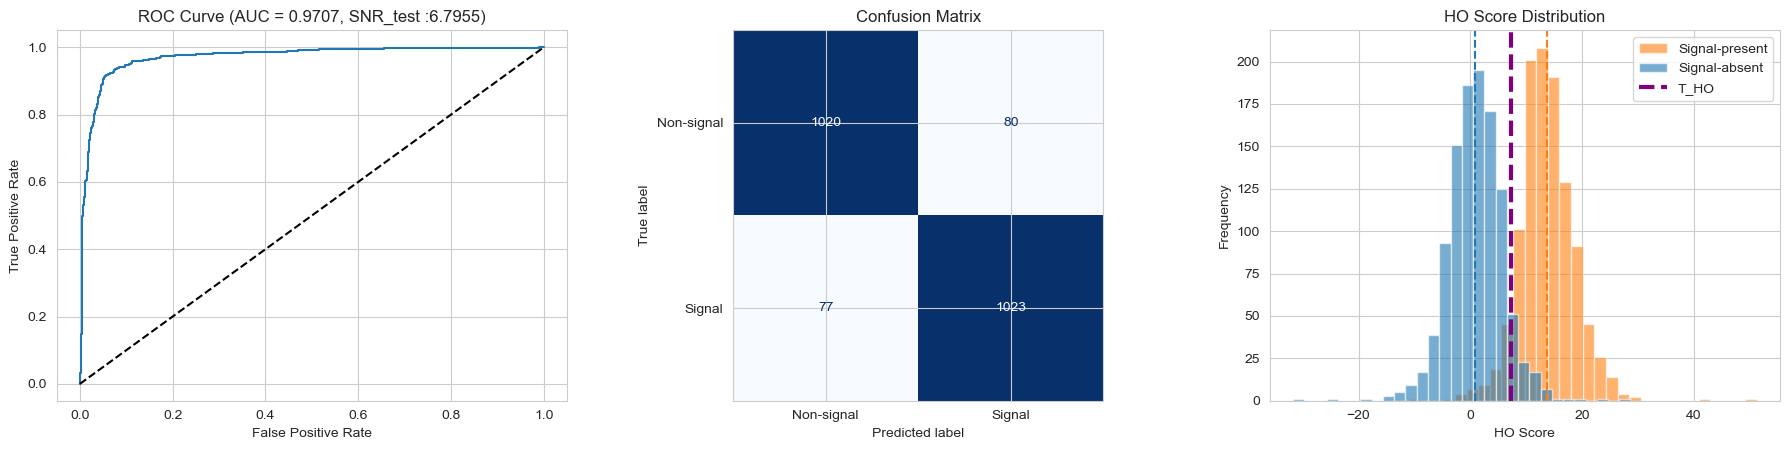

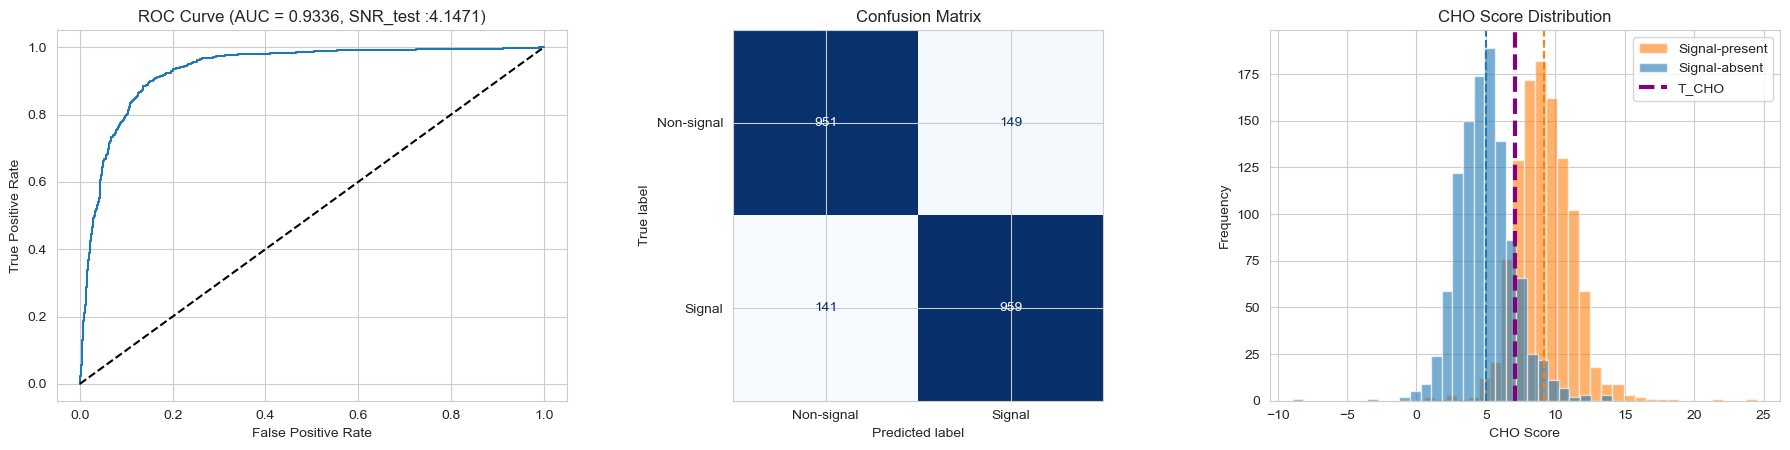


=== Showing results for: patches_amp_0.05_noise_0.0001_accel_4.npy ===


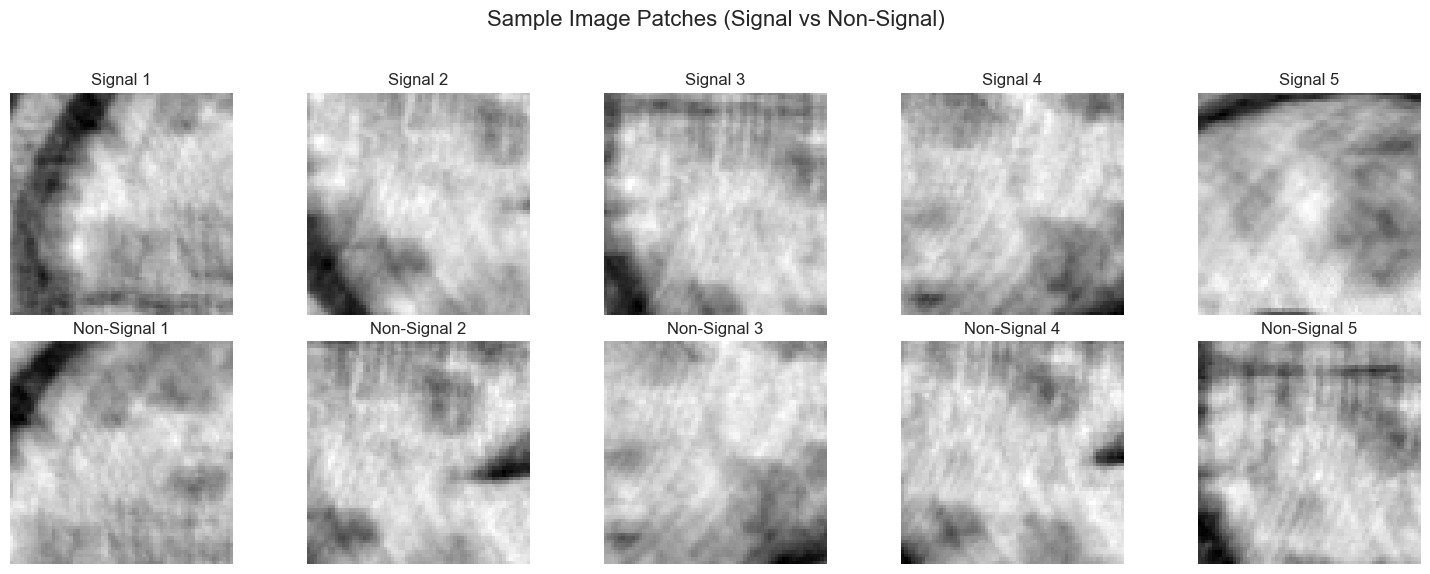

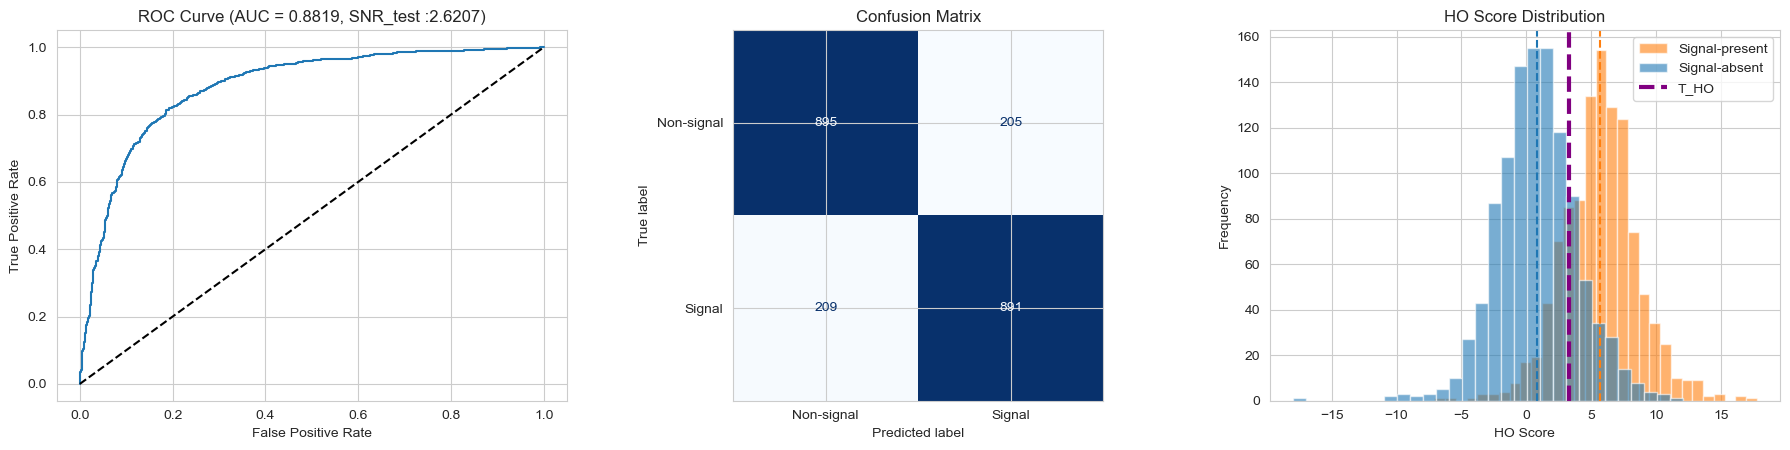

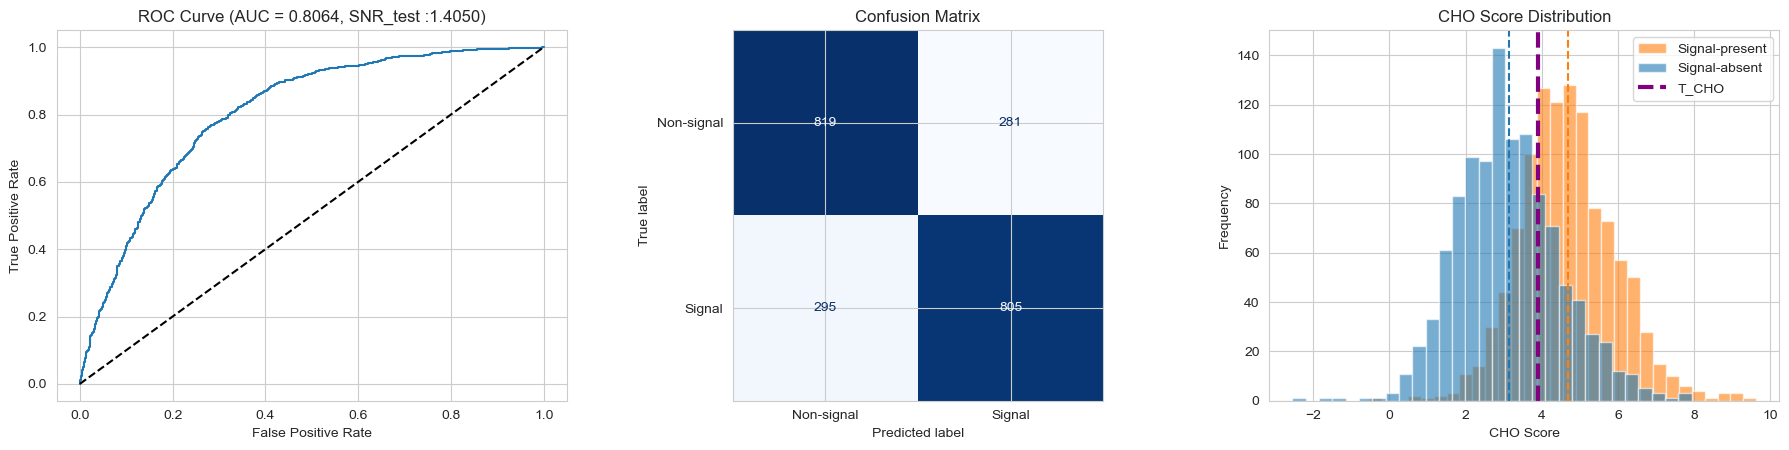


=== Showing results for: patches_amp_0.05_noise_0.0004_accel_2.npy ===


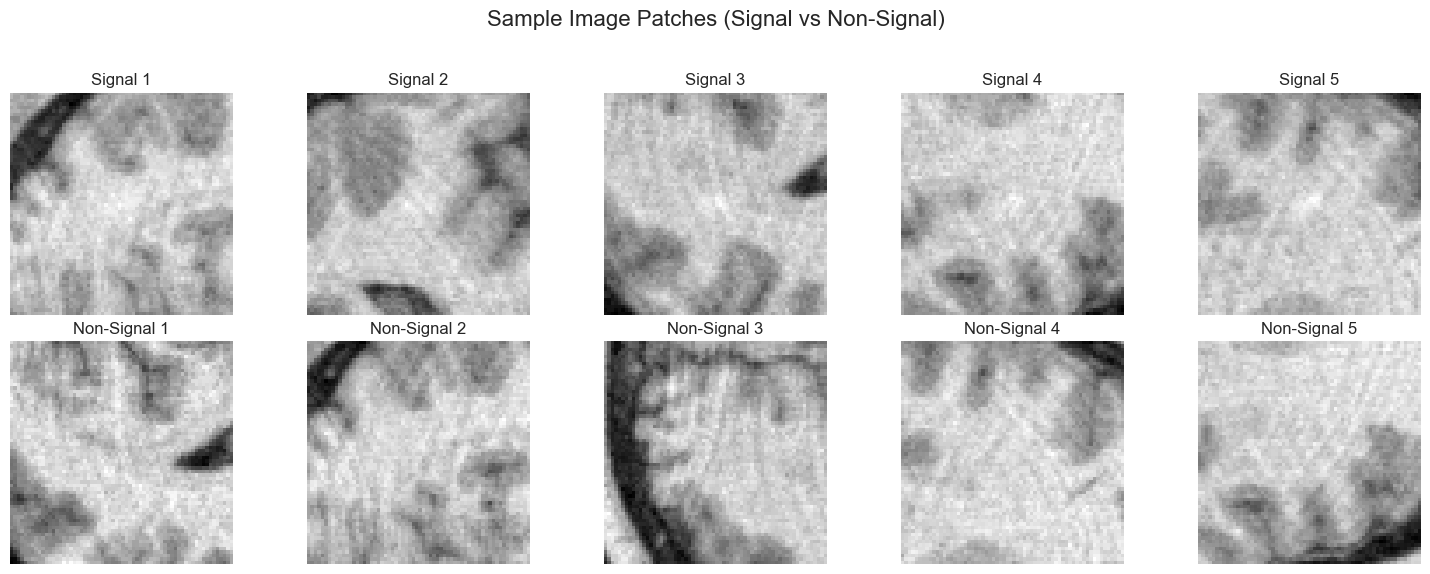

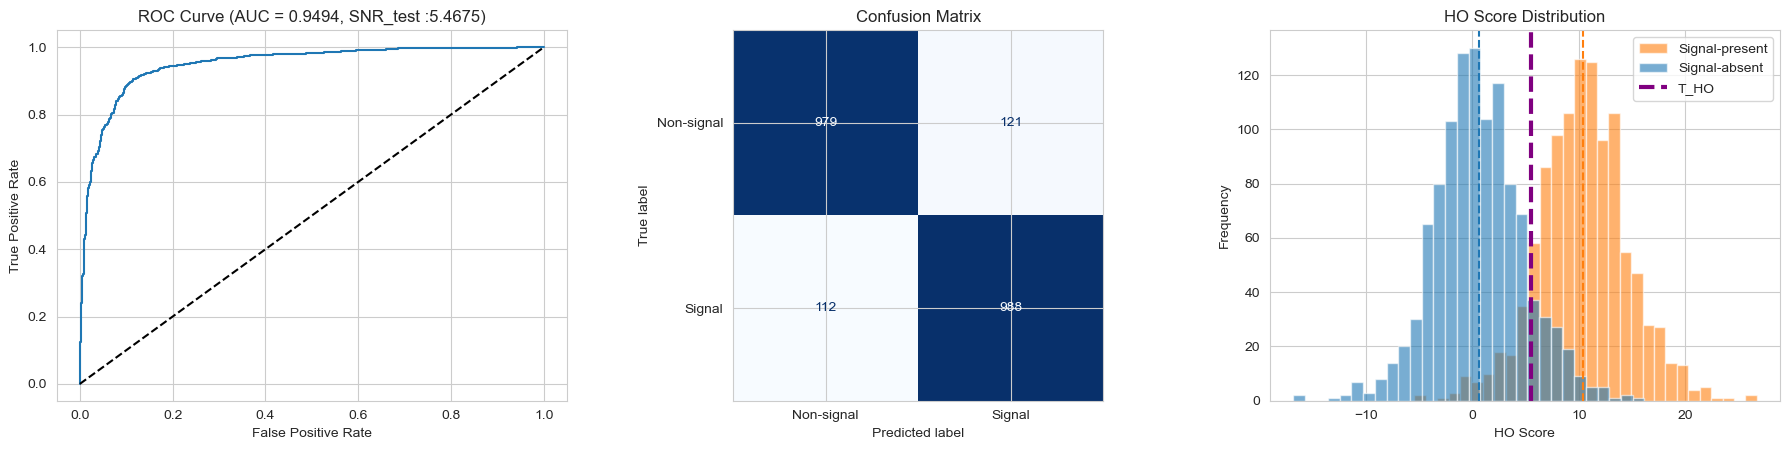

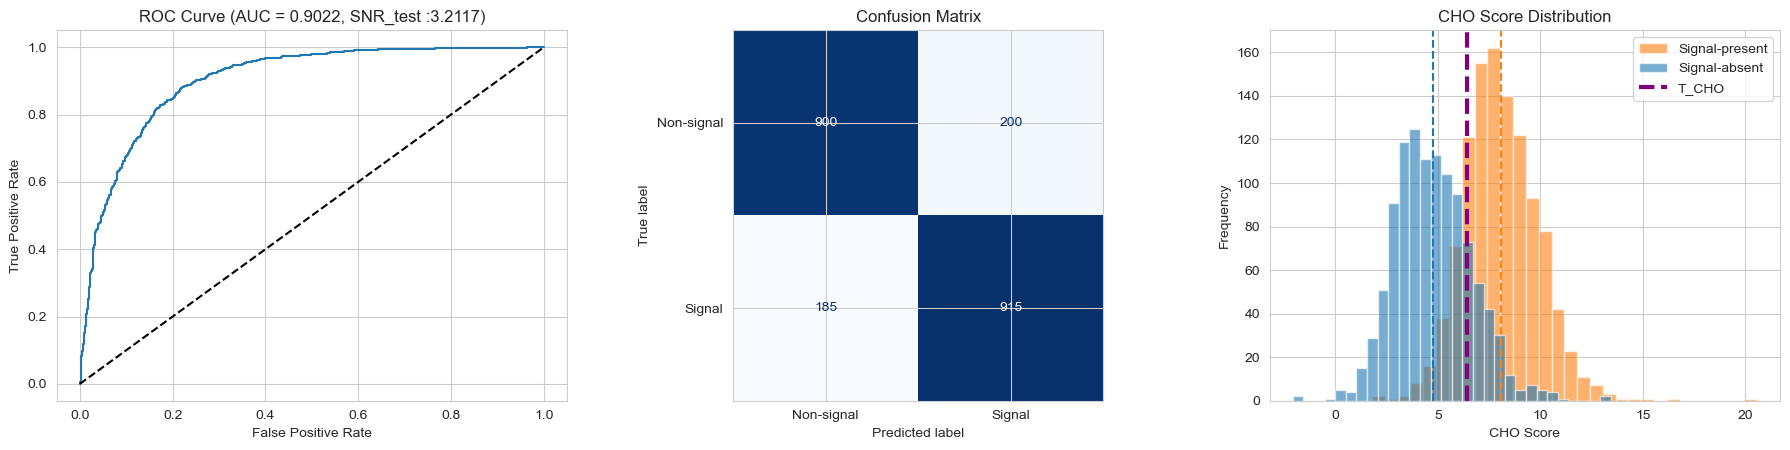


=== Showing results for: patches_amp_0.05_noise_0.0004_accel_4.npy ===


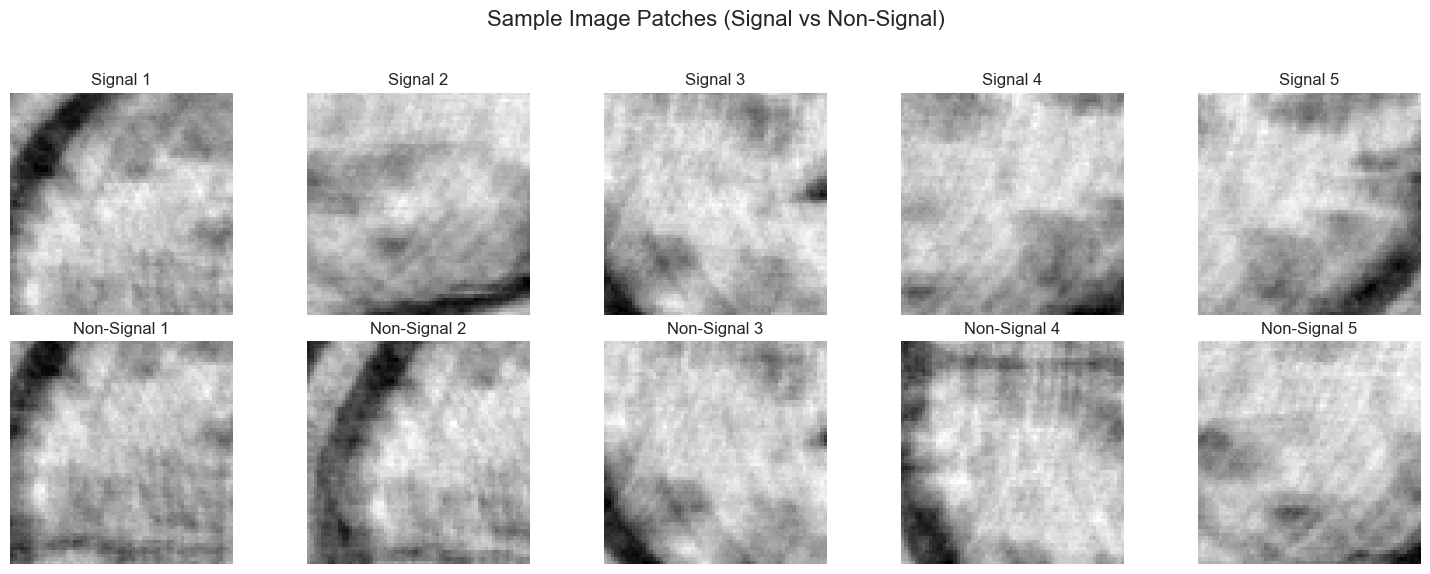

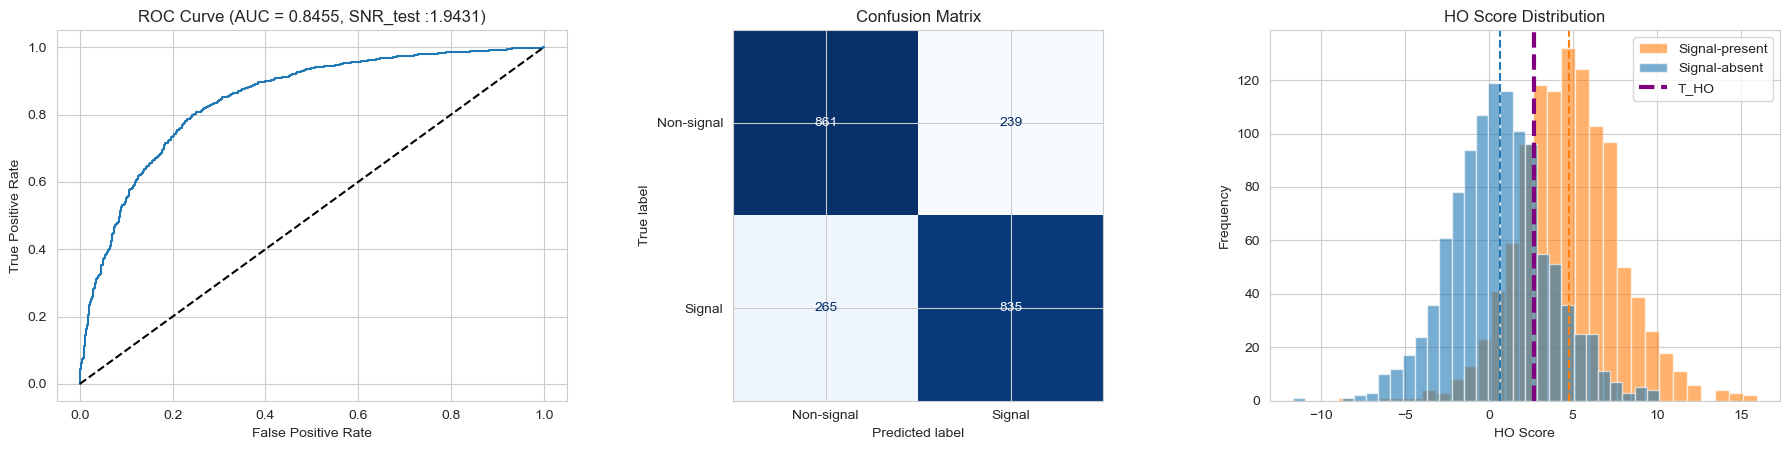

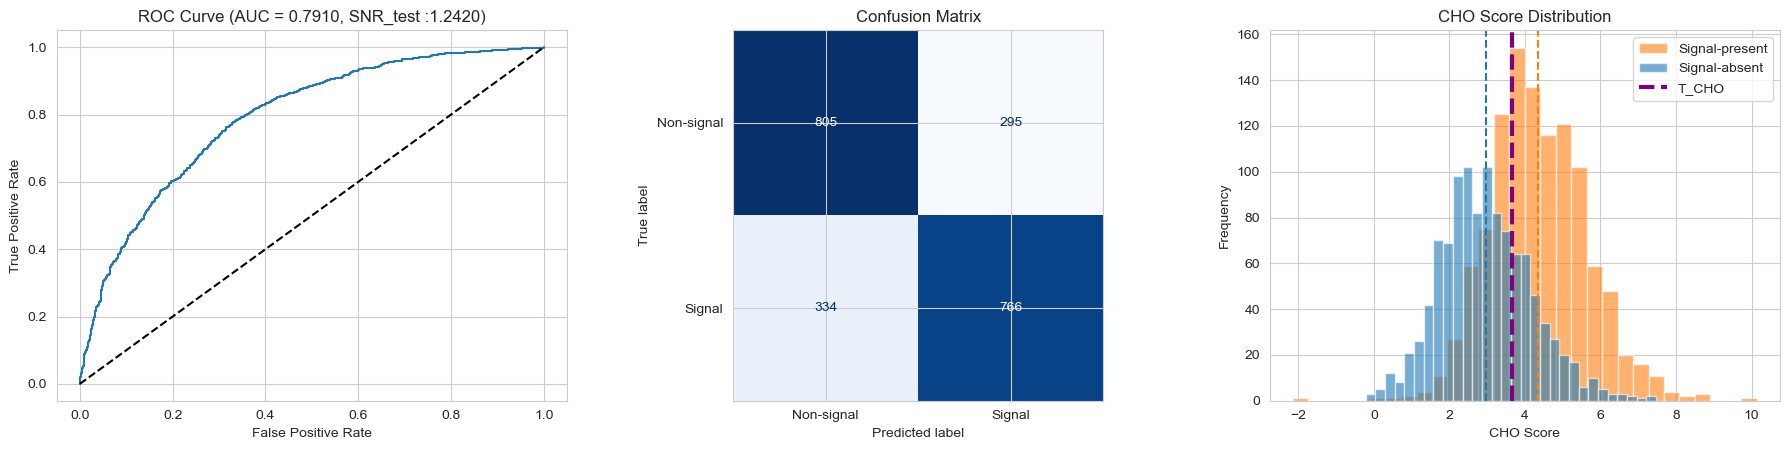


=== Showing results for: patches_amp_0.05_noise_0.001_accel_2.npy ===


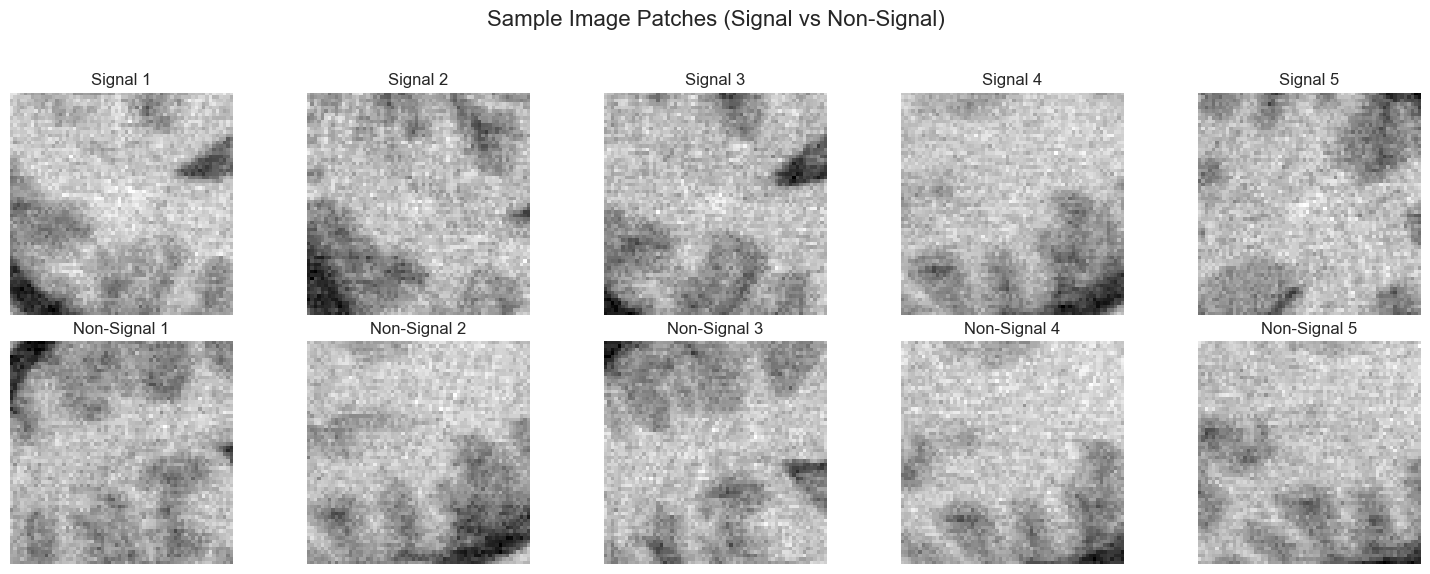

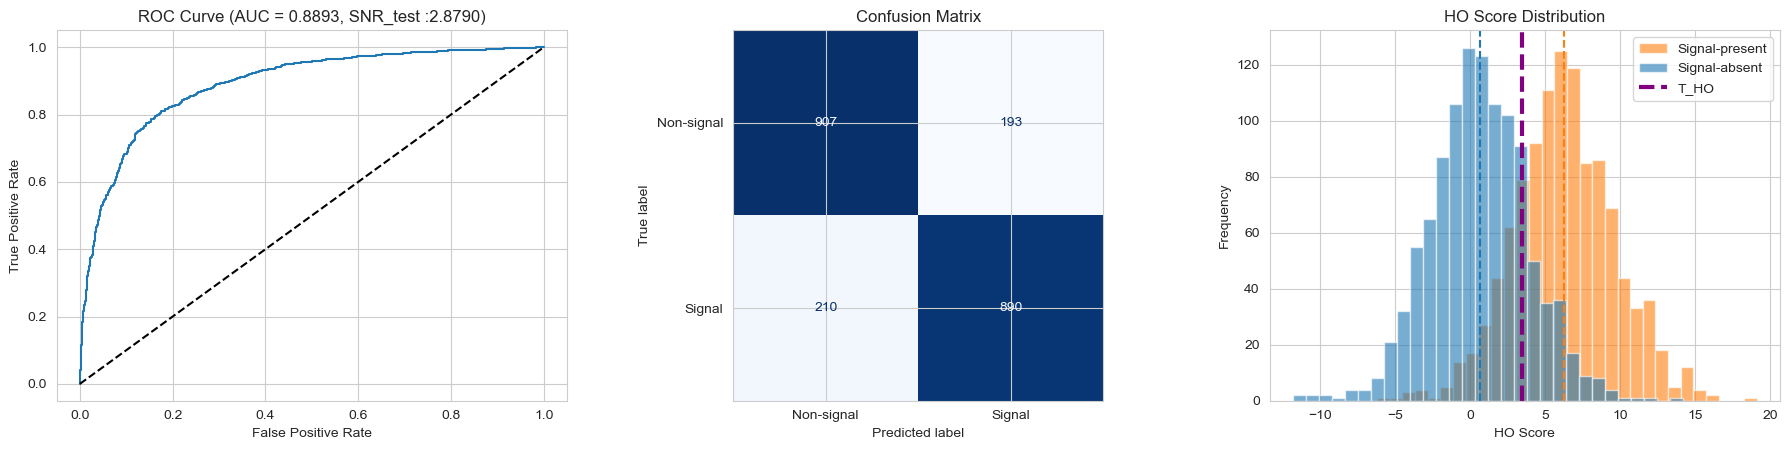

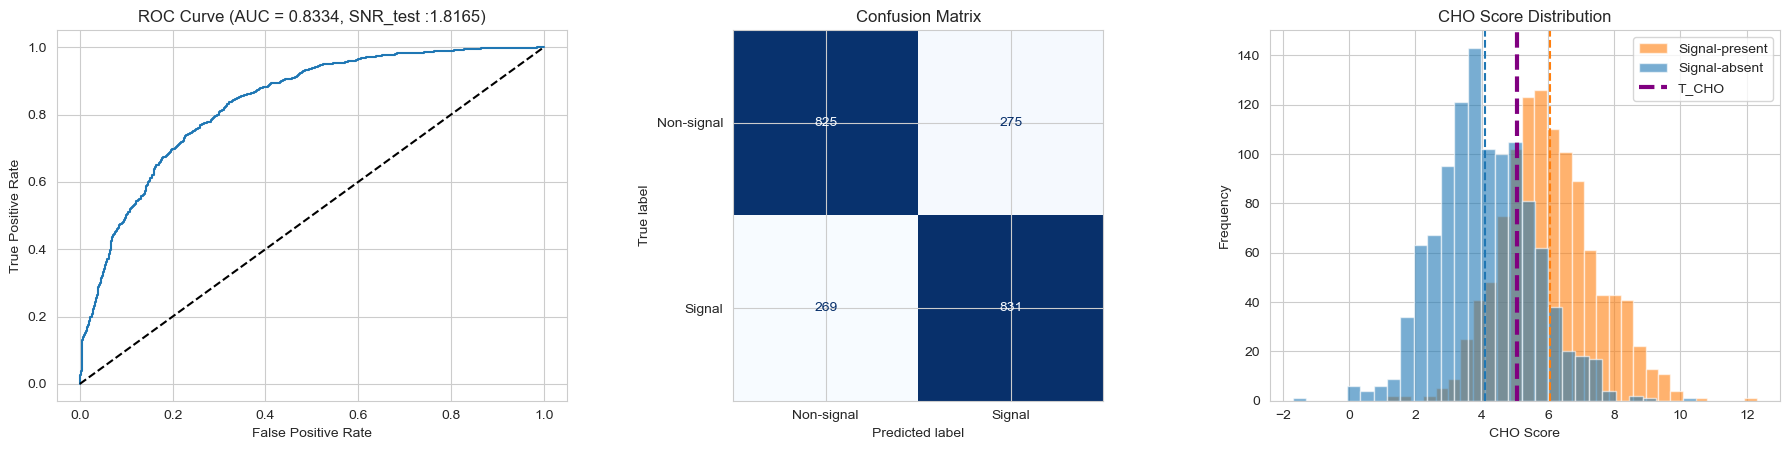


=== Showing results for: patches_amp_0.05_noise_0.001_accel_4.npy ===


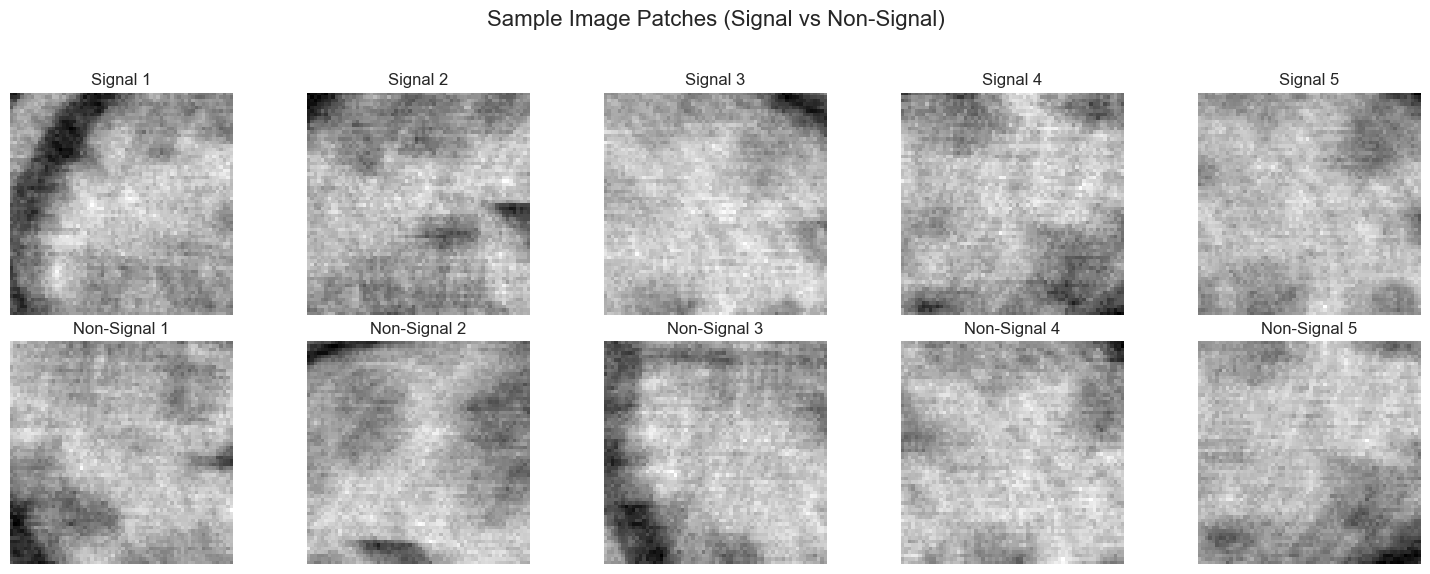

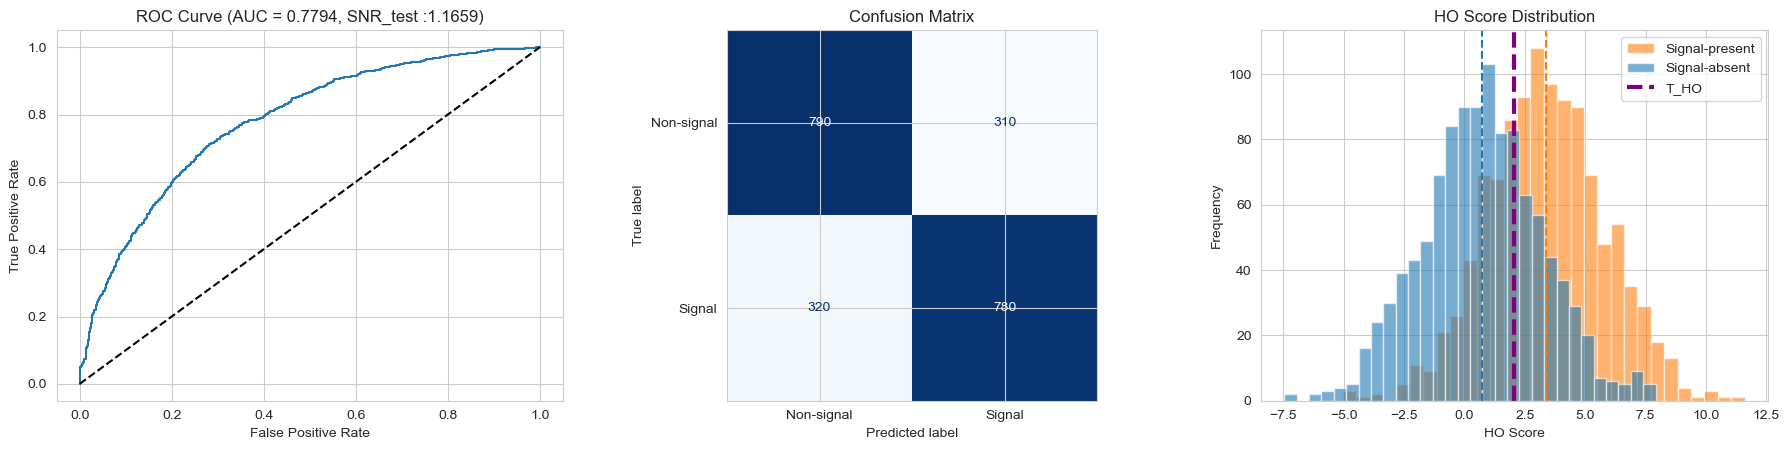

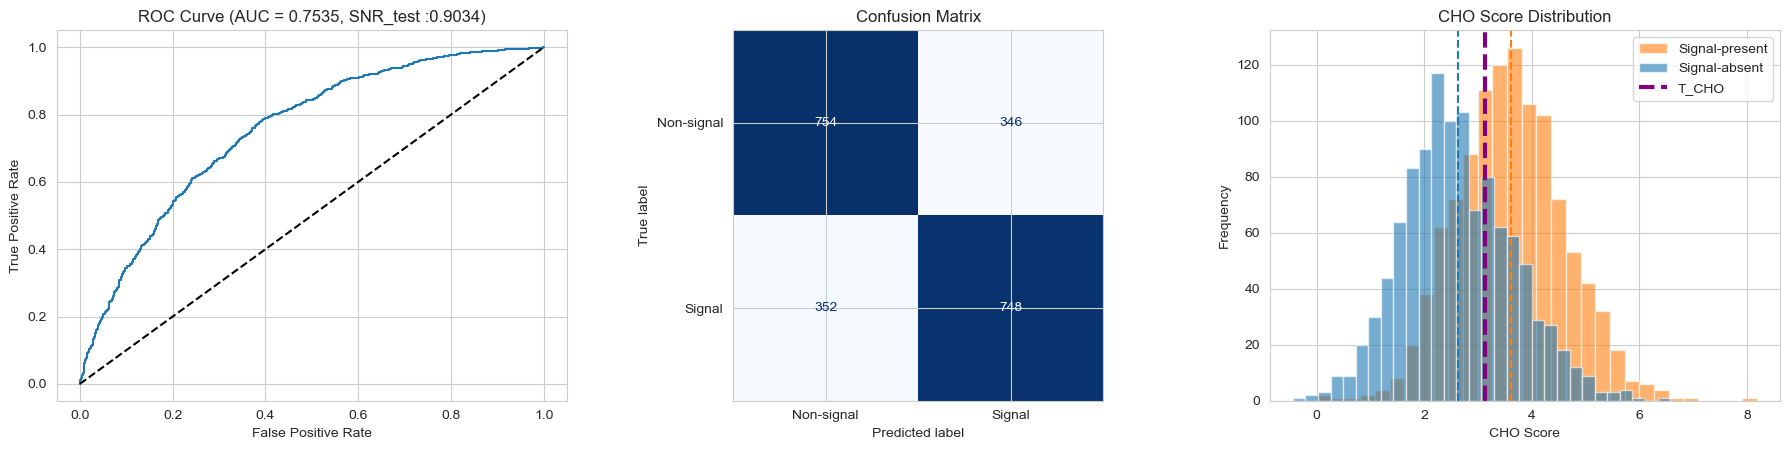


=== Showing results for: patches_amp_0.05_noise_0.004_accel_2.npy ===


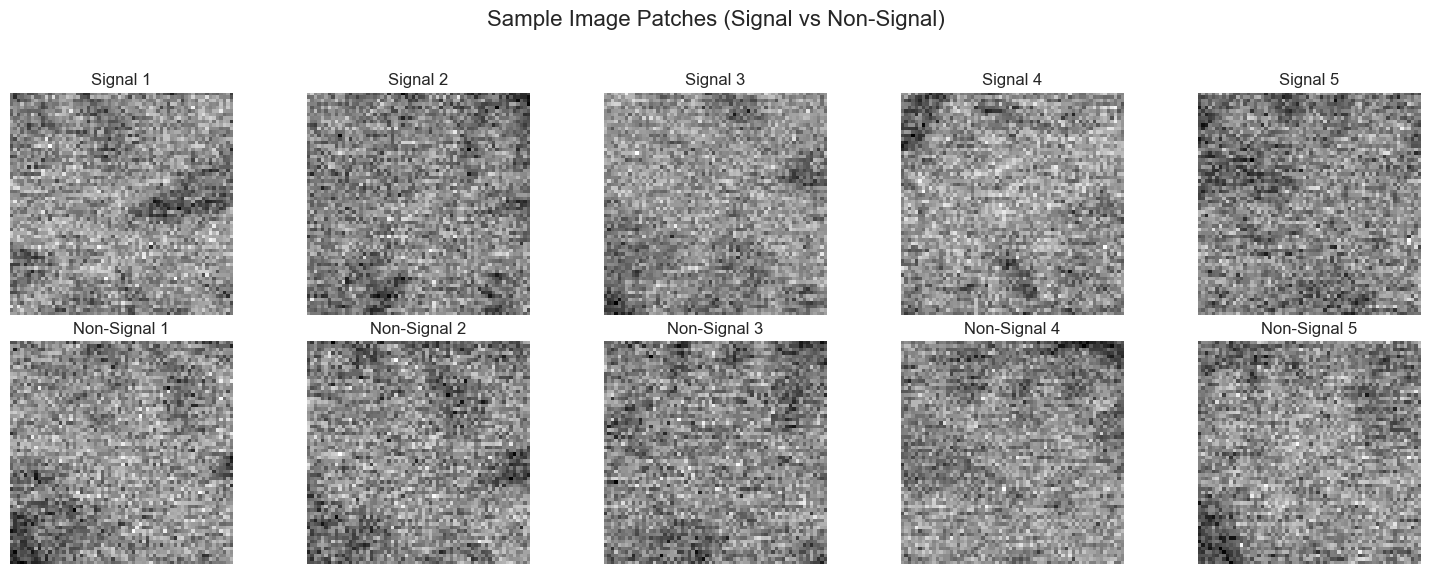

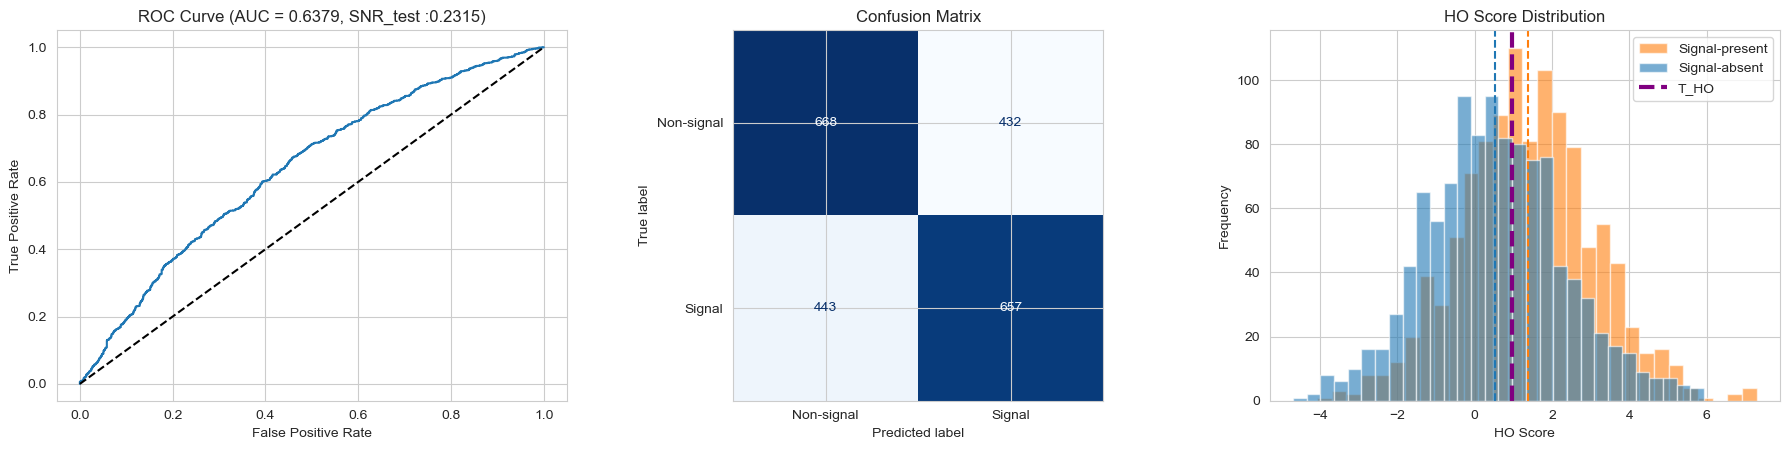

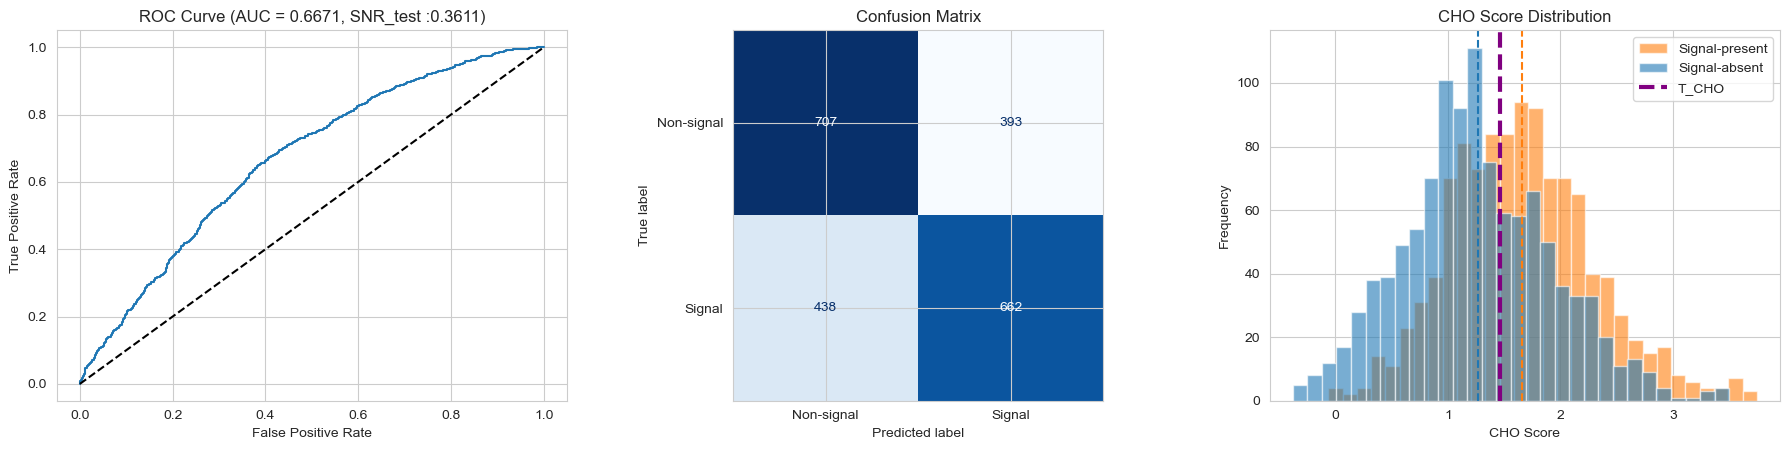


=== Showing results for: patches_amp_0.05_noise_0.004_accel_4.npy ===


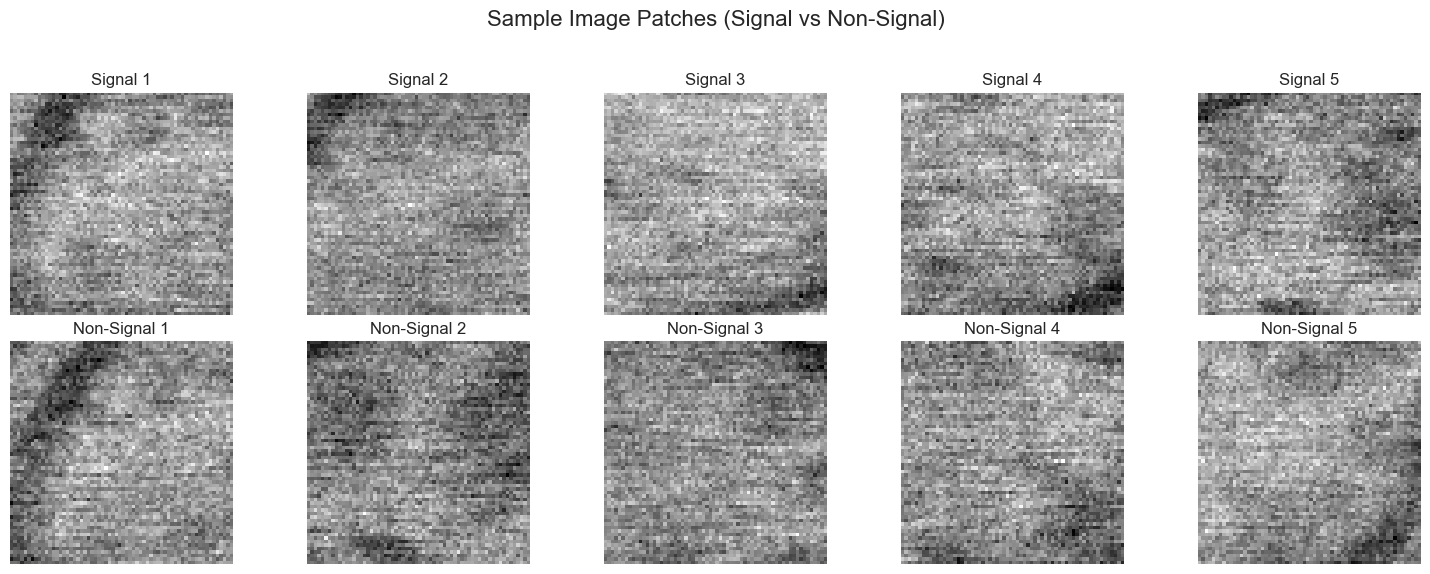

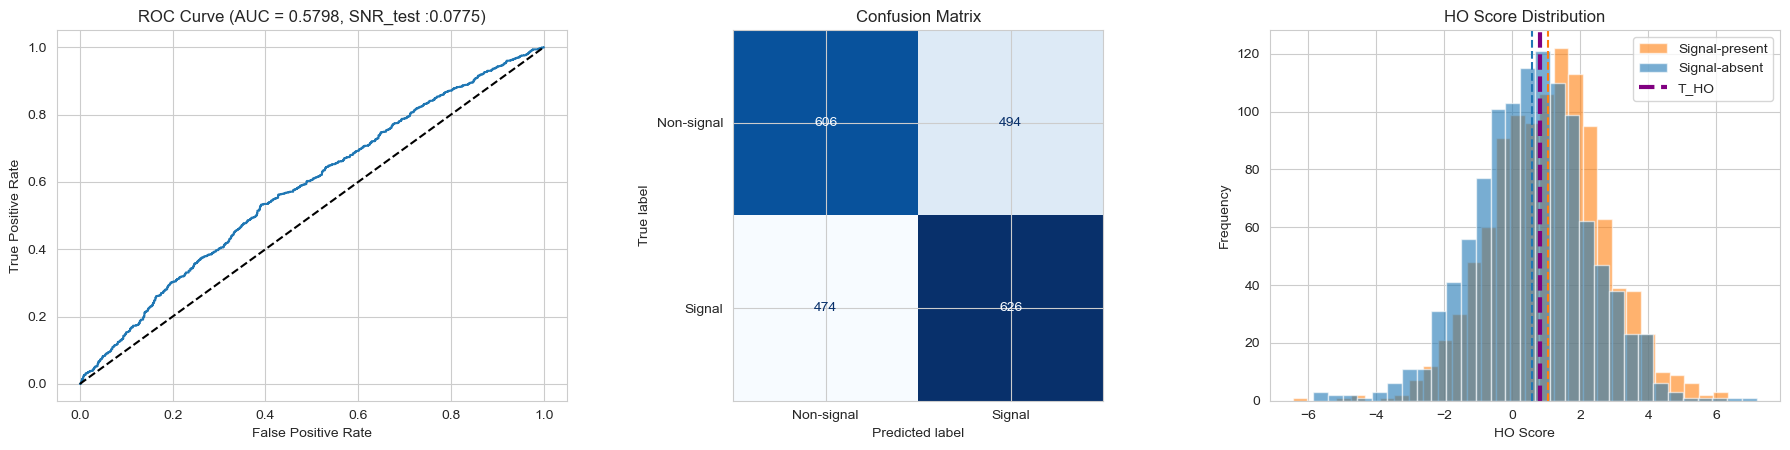

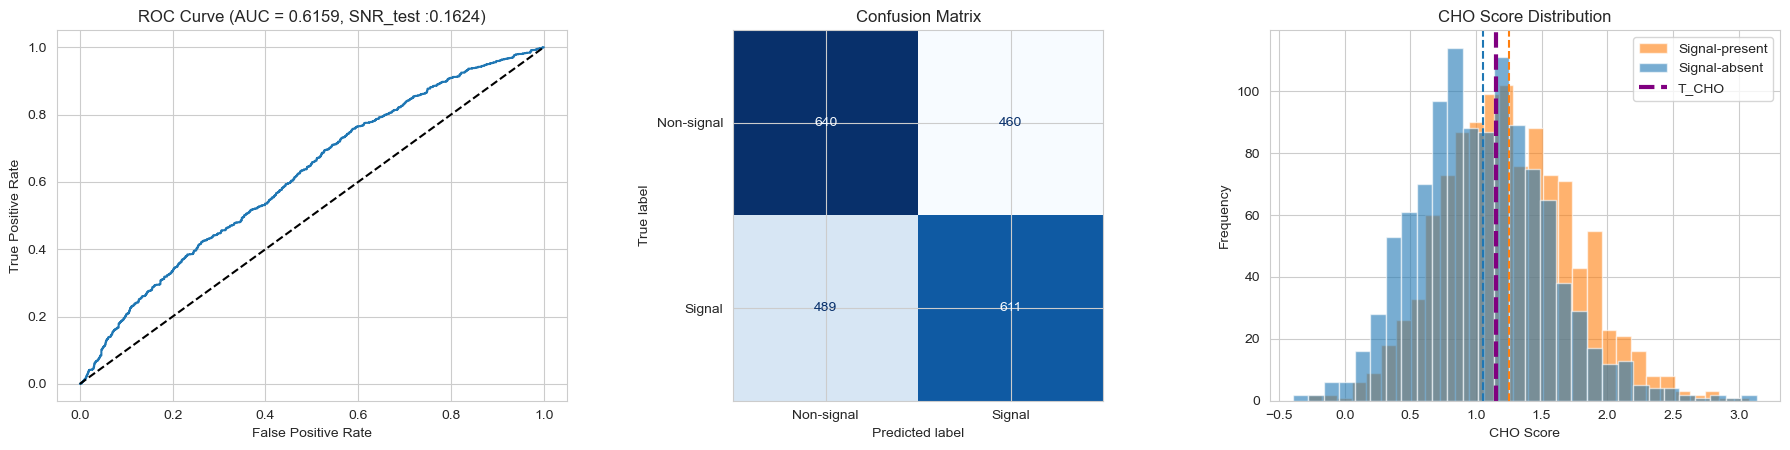


=== Showing results for: patches_amp_0.05_noise_0.008_accel_2.npy ===


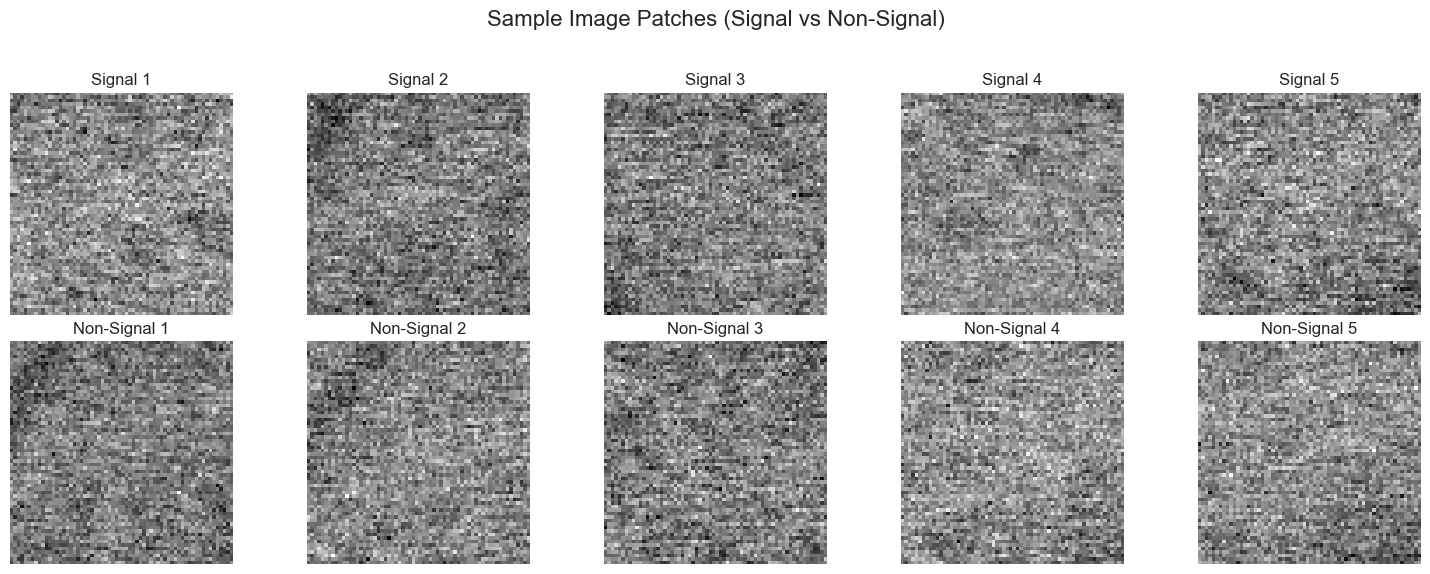

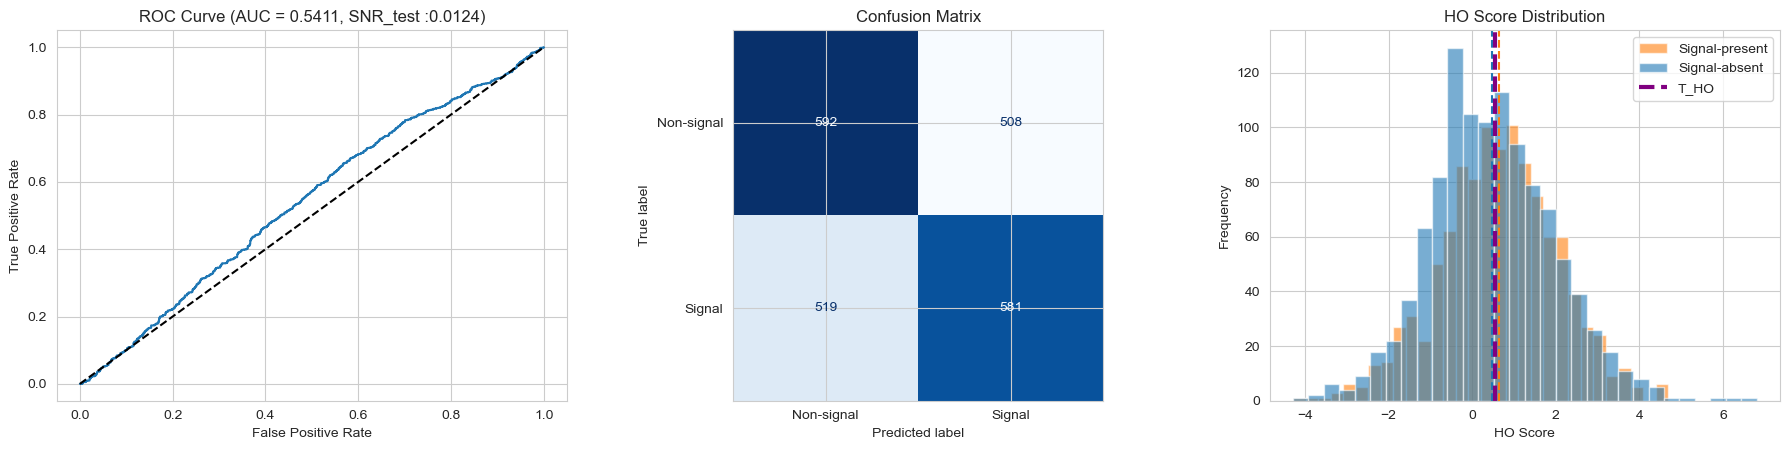

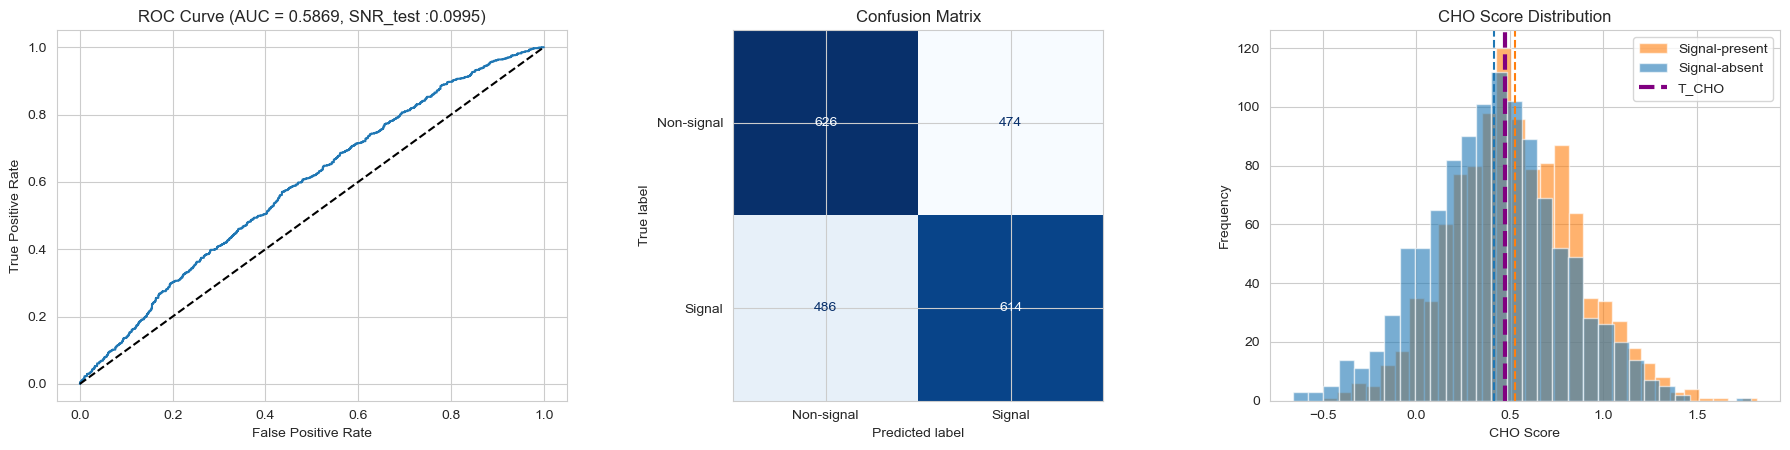


=== Showing results for: patches_amp_0.05_noise_0.008_accel_4.npy ===


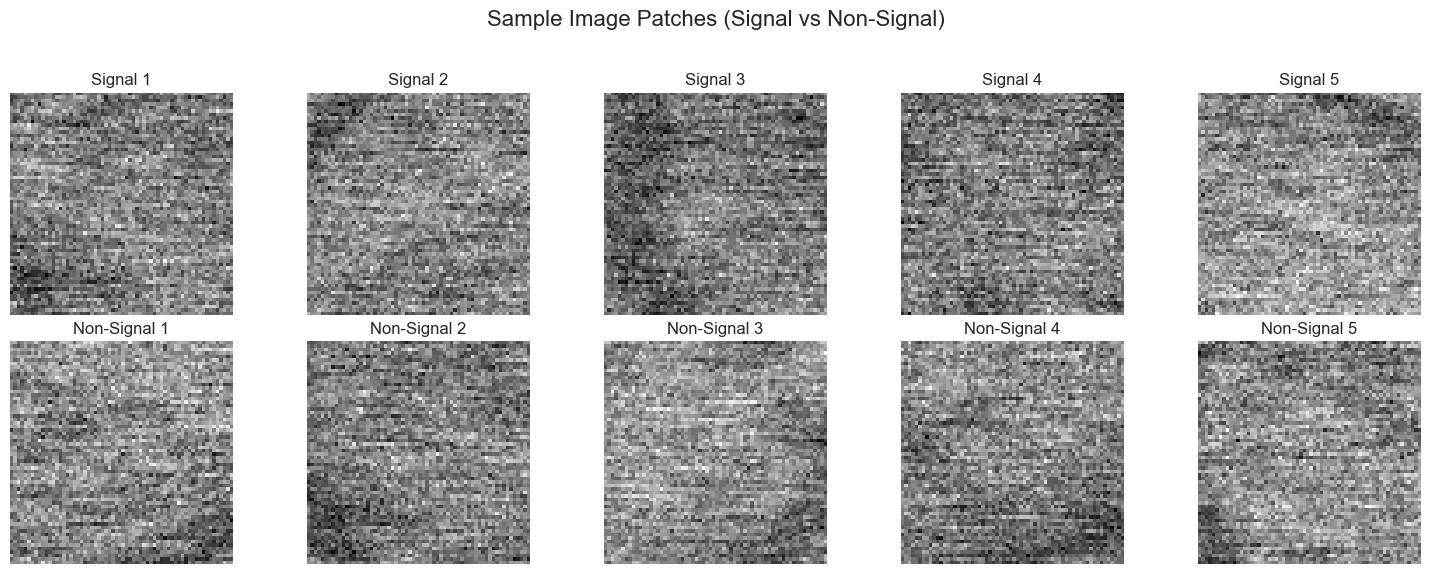

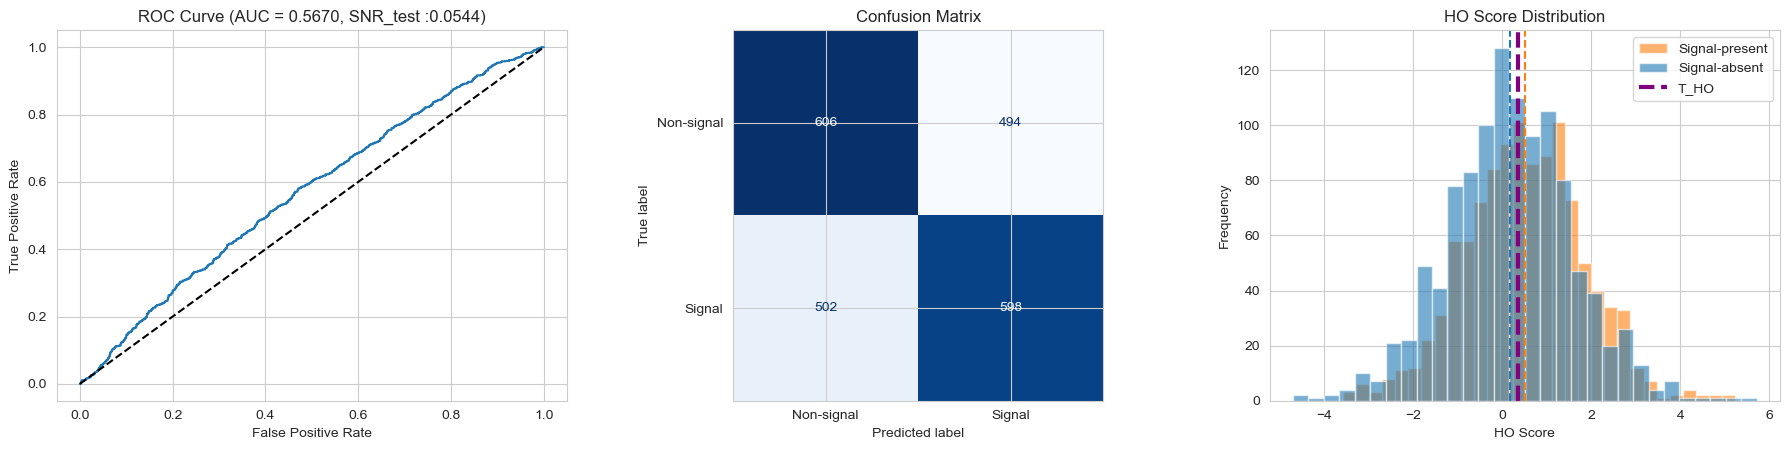

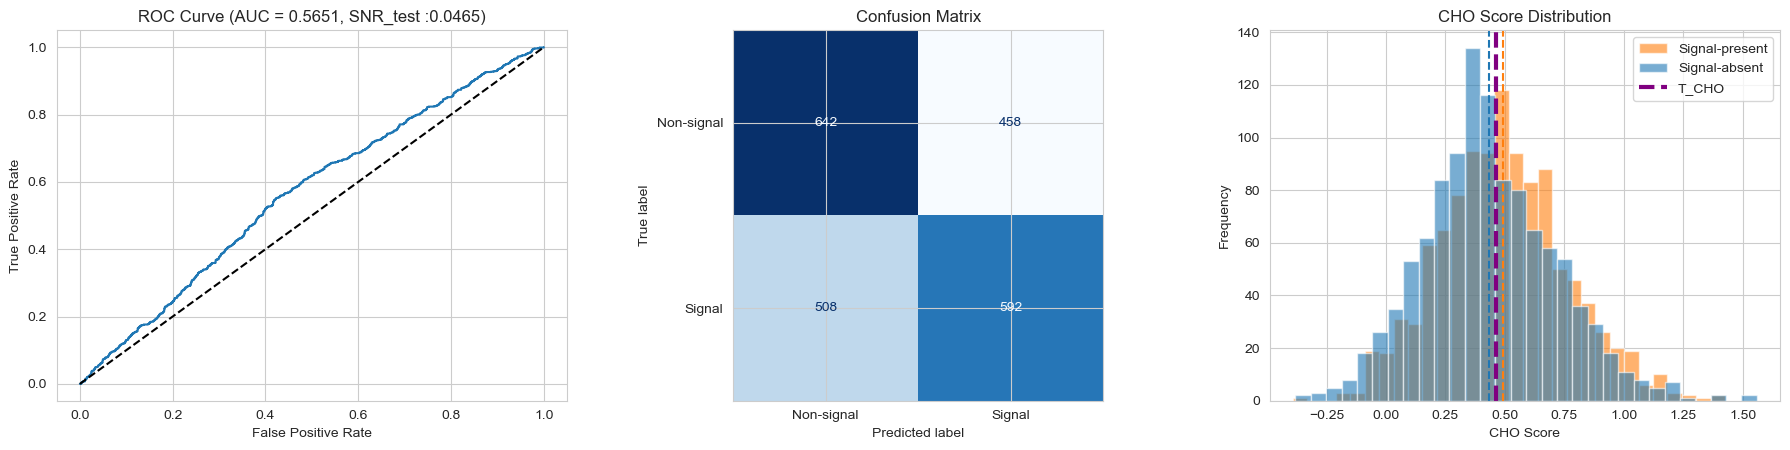


=== Showing results for: patches_amp_0.2_noise_0.0001_accel_2.npy ===


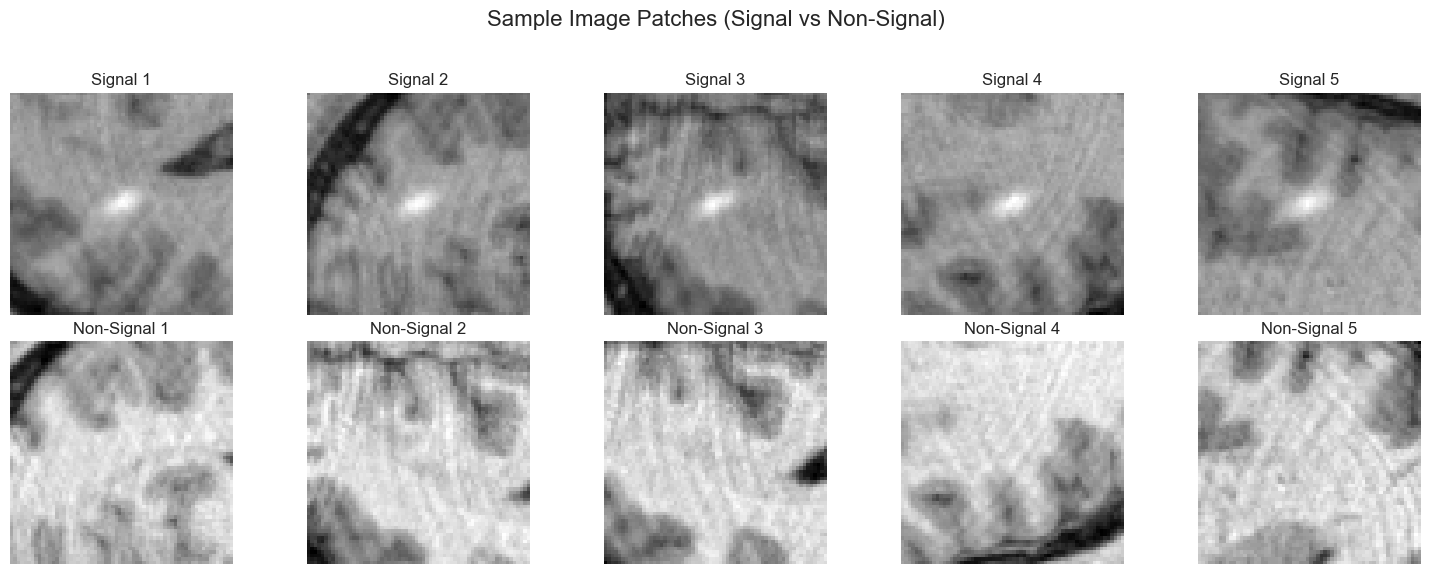

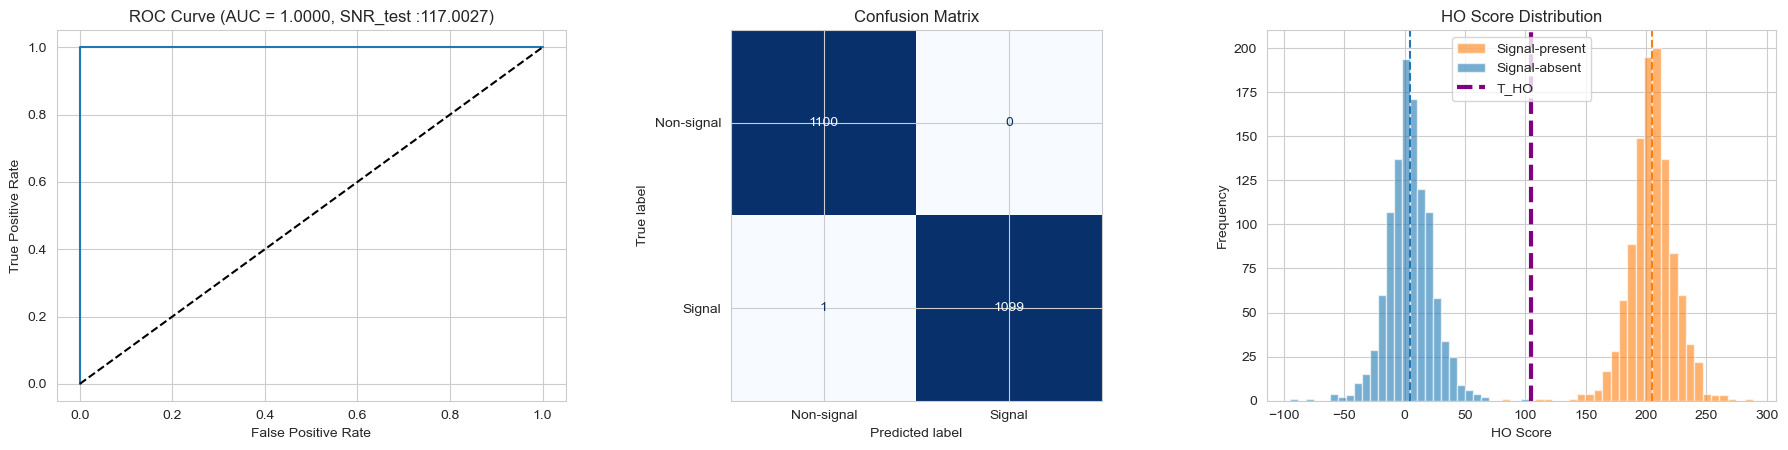

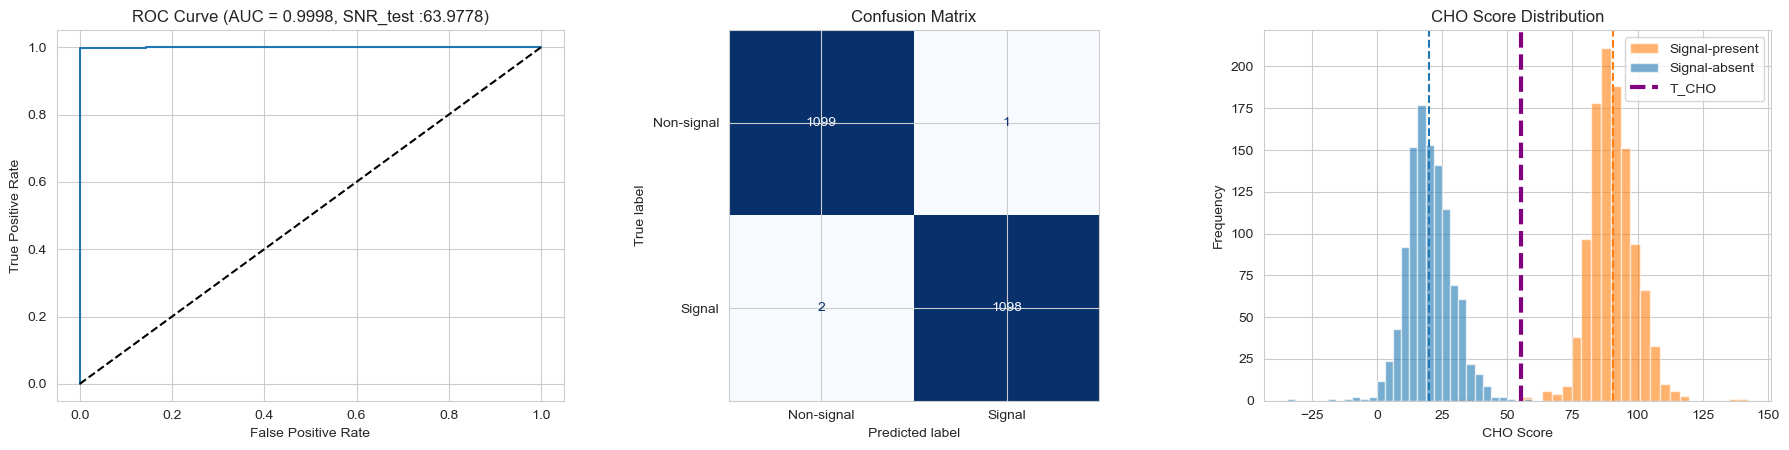


=== Showing results for: patches_amp_0.2_noise_0.0001_accel_4.npy ===


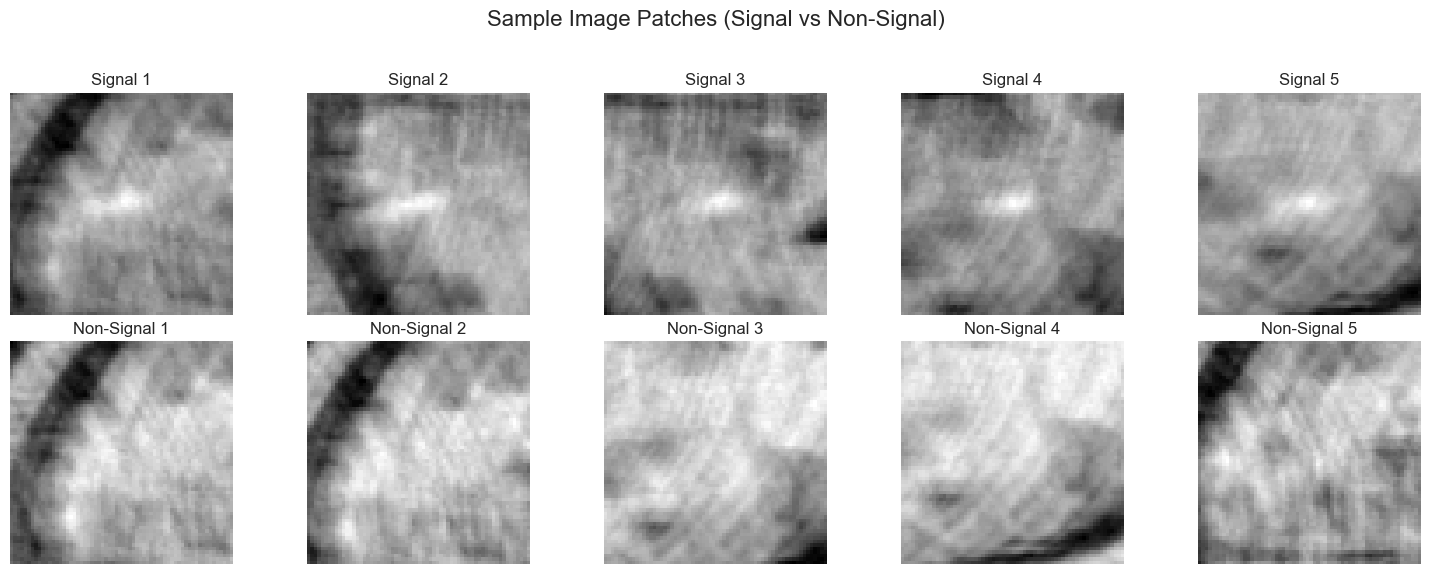

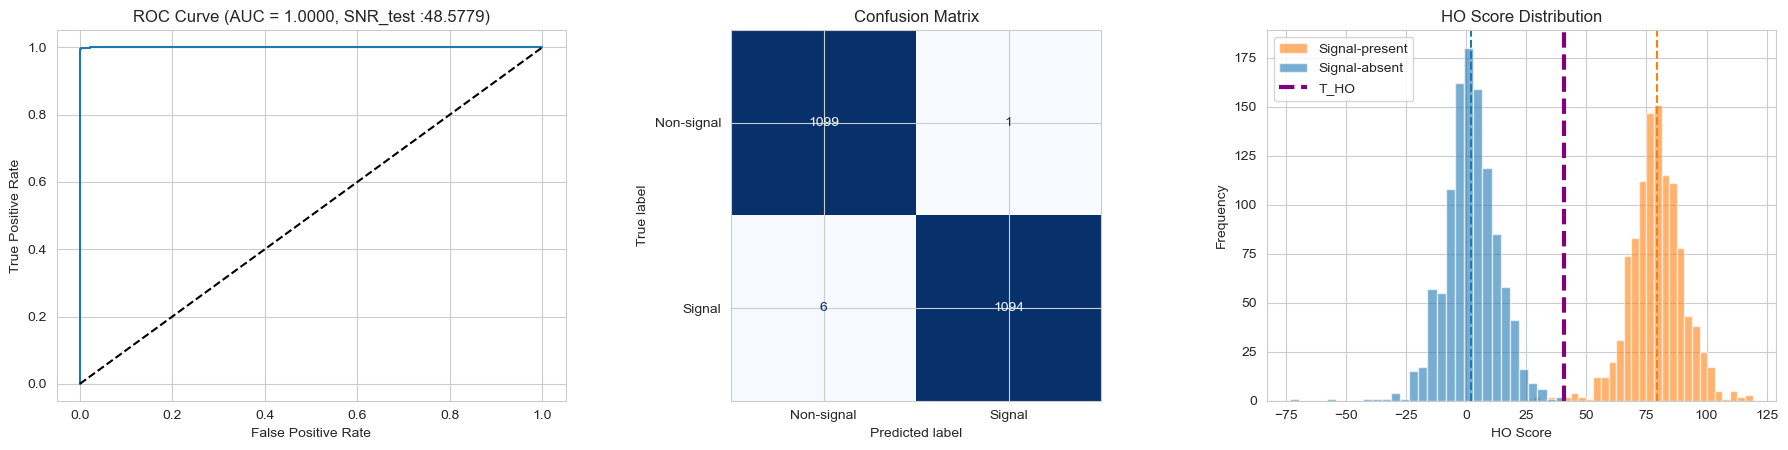

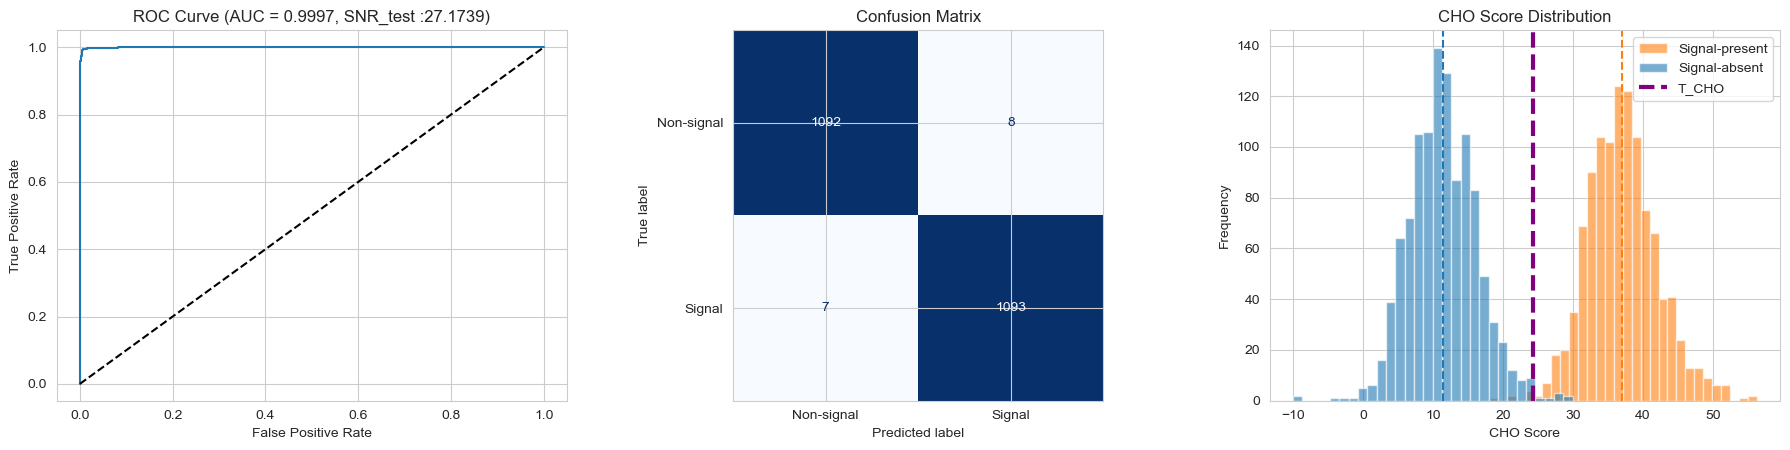


=== Showing results for: patches_amp_0.2_noise_0.0004_accel_2.npy ===


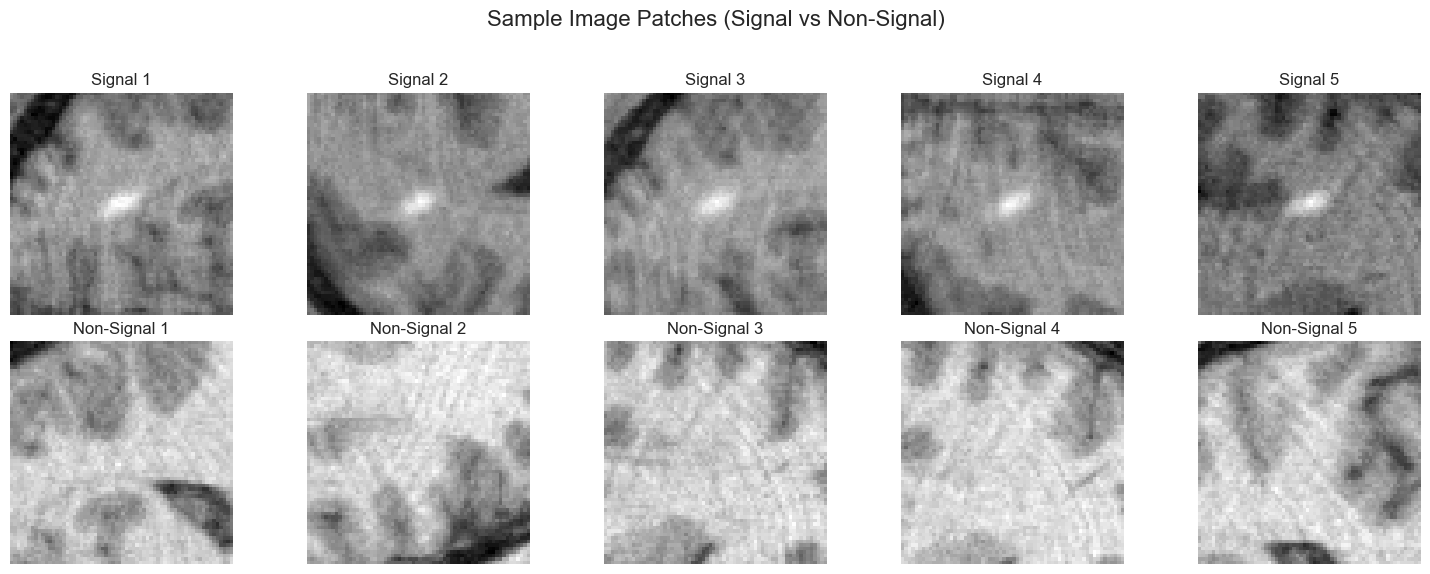

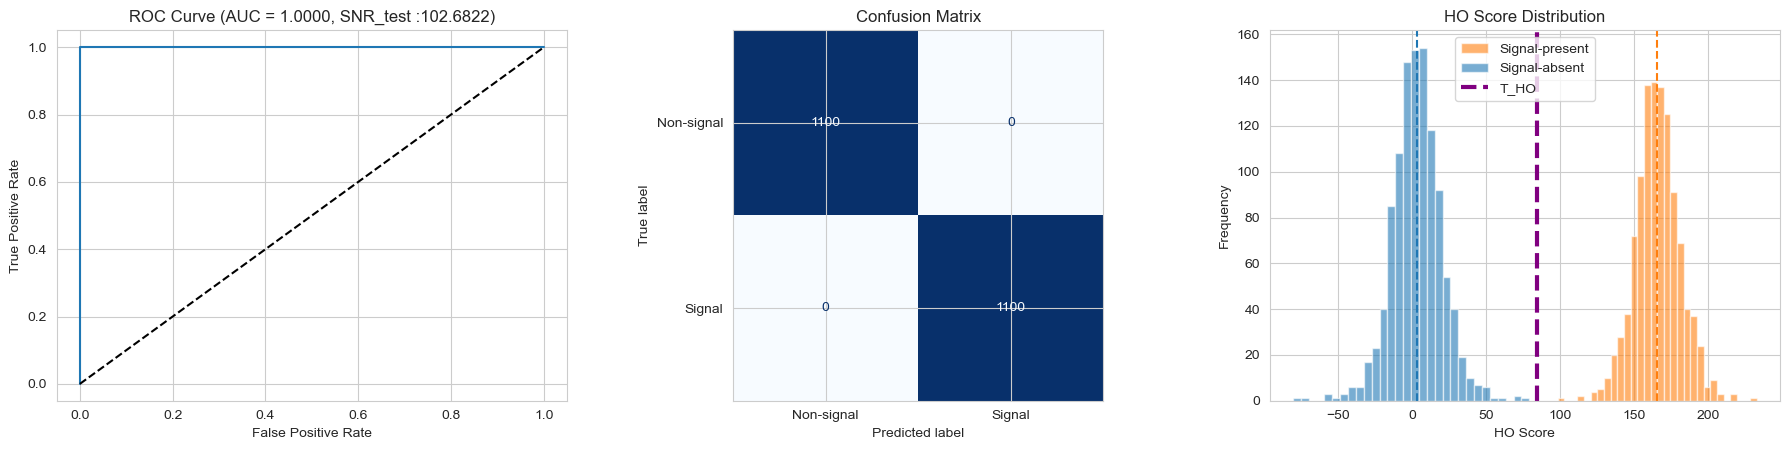

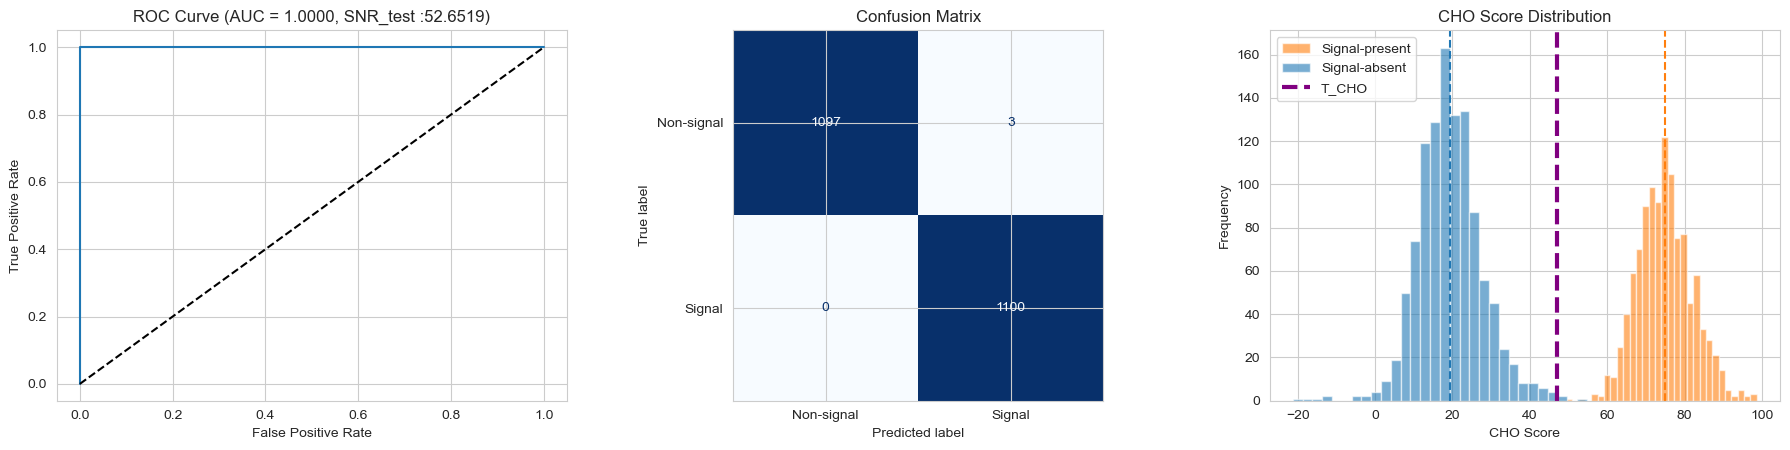


=== Showing results for: patches_amp_0.2_noise_0.0004_accel_4.npy ===


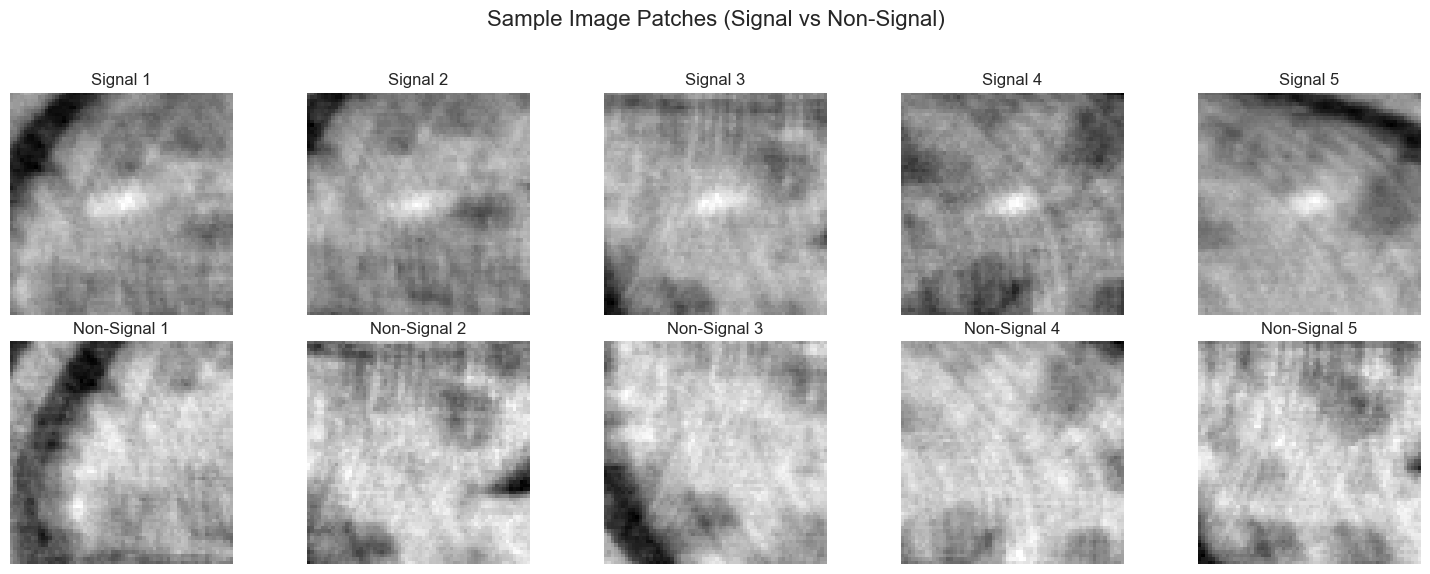

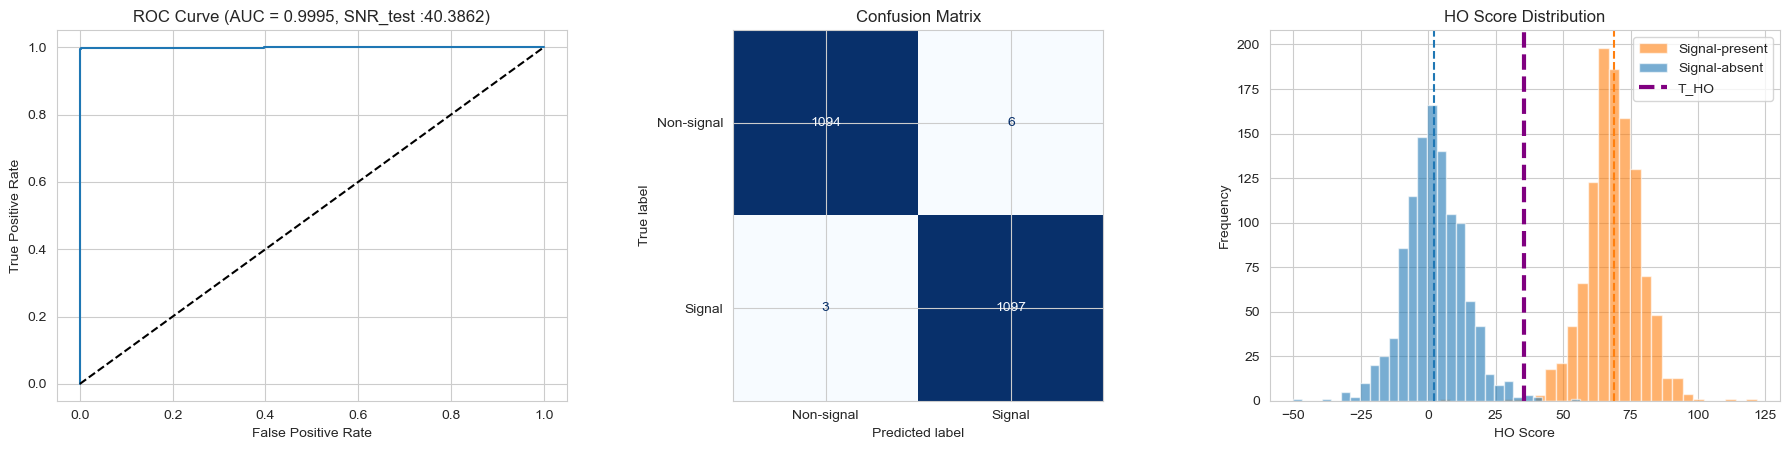

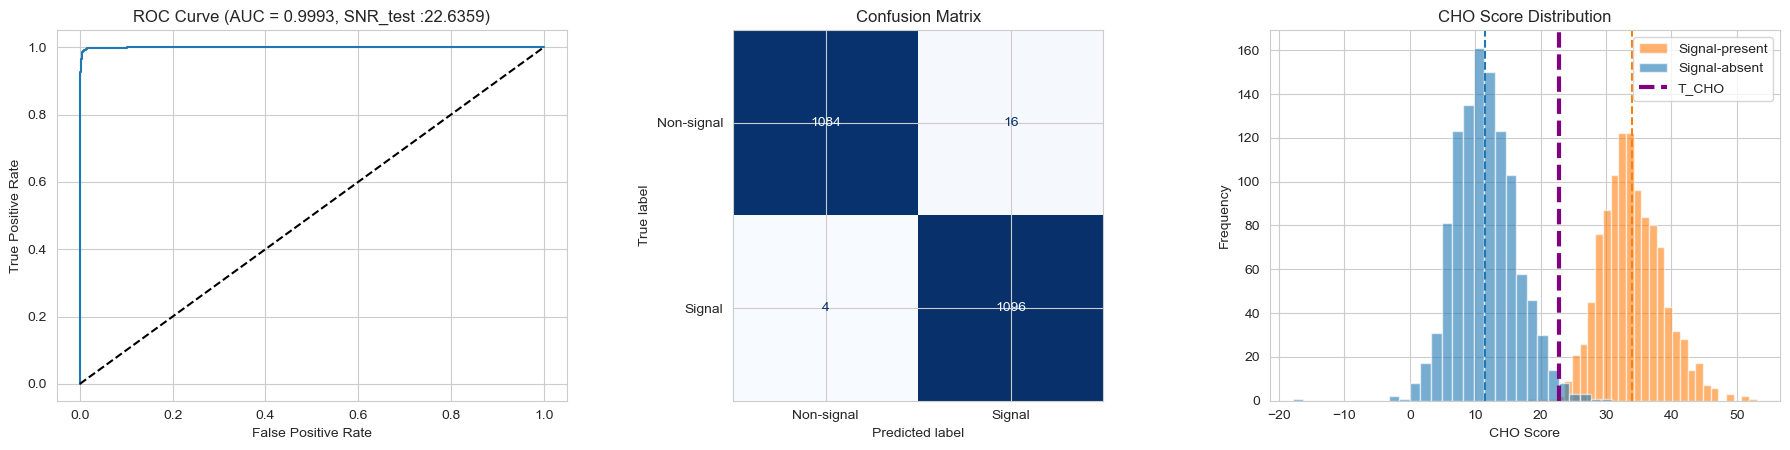


=== Showing results for: patches_amp_0.2_noise_0.001_accel_2.npy ===


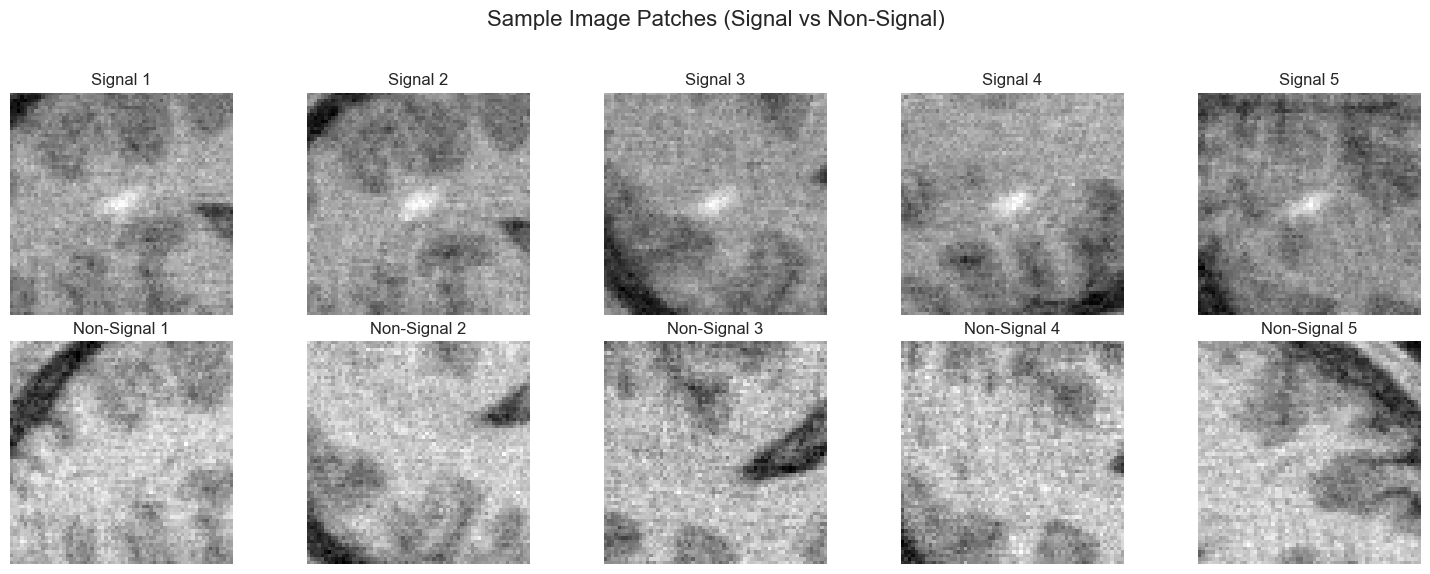

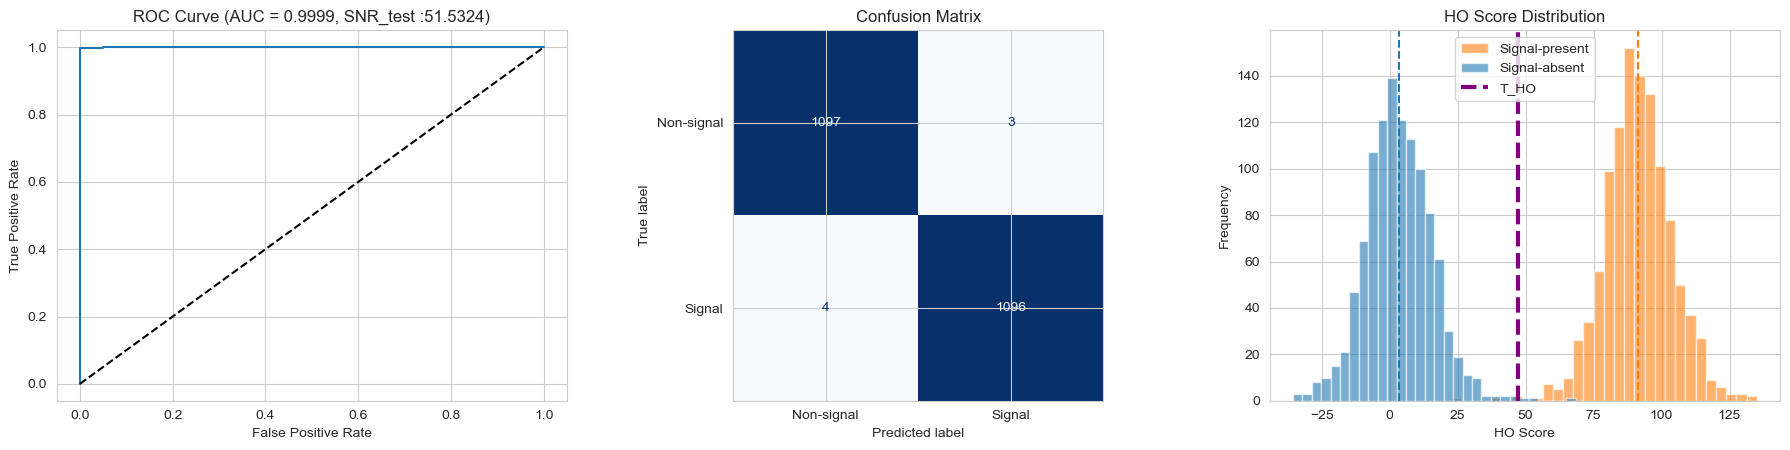

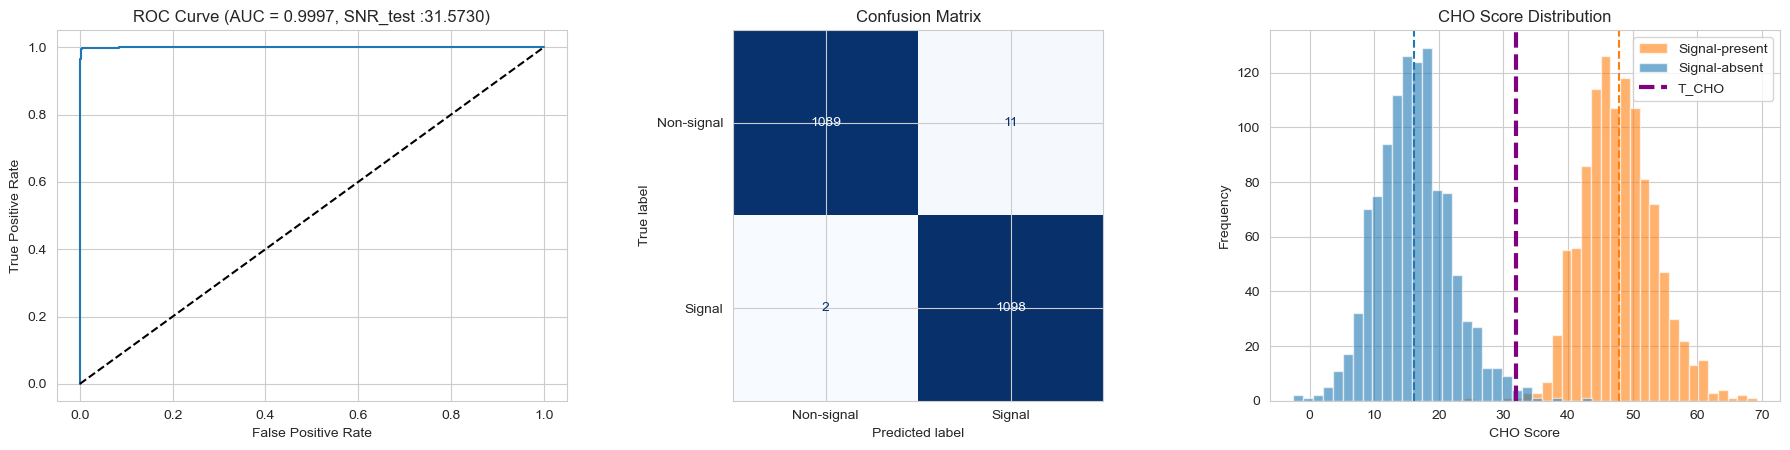


=== Showing results for: patches_amp_0.2_noise_0.001_accel_4.npy ===


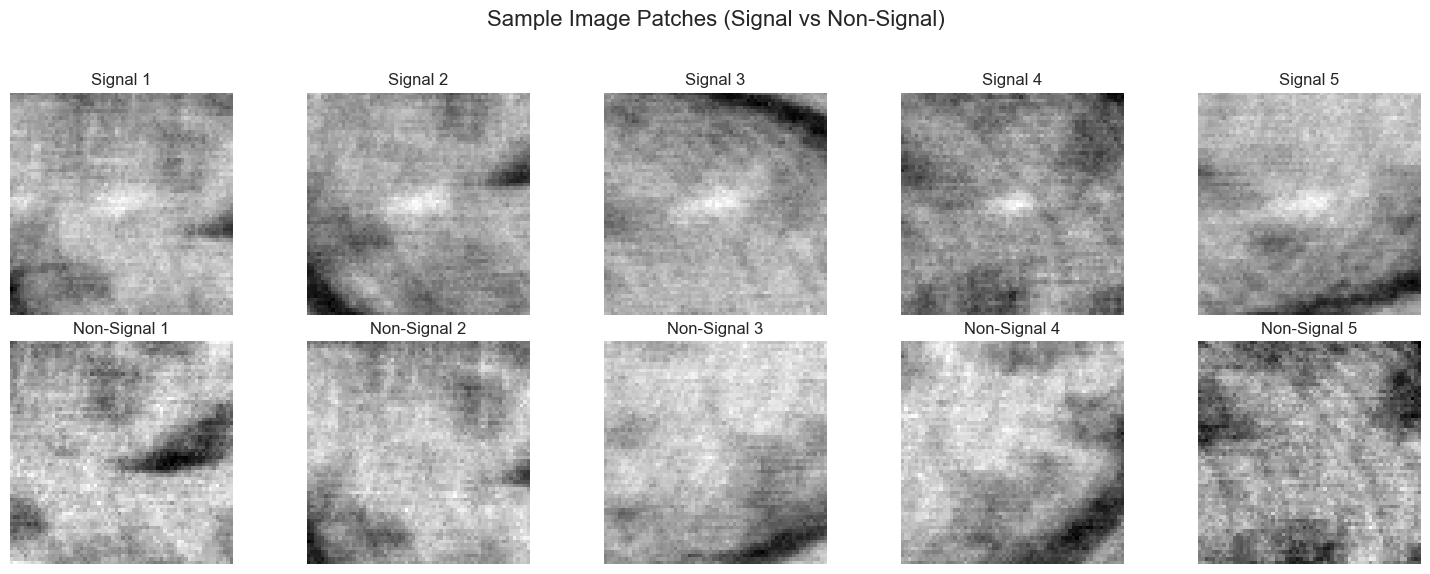

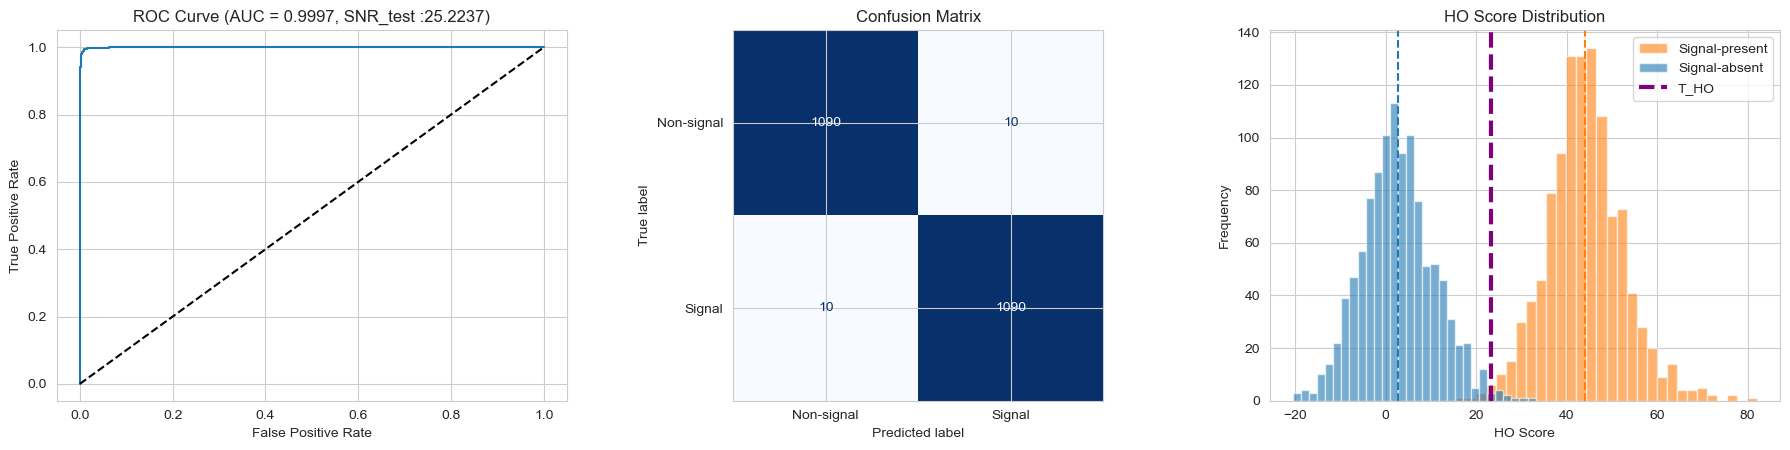

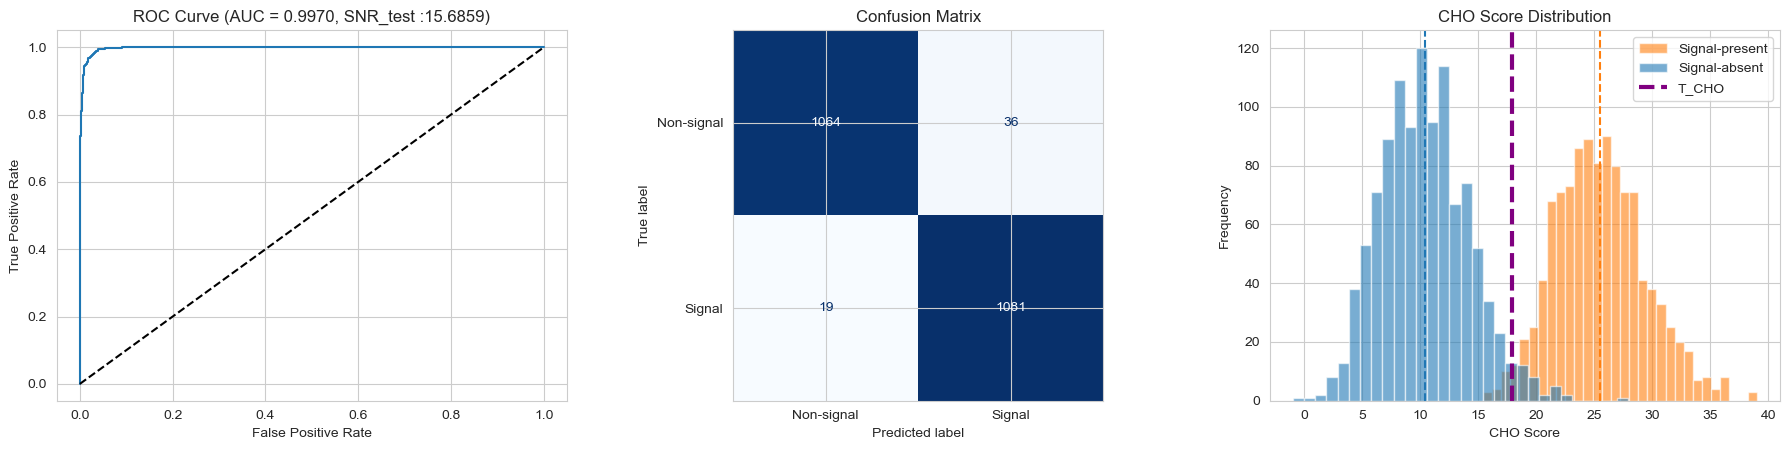


=== Showing results for: patches_amp_0.2_noise_0.004_accel_2.npy ===


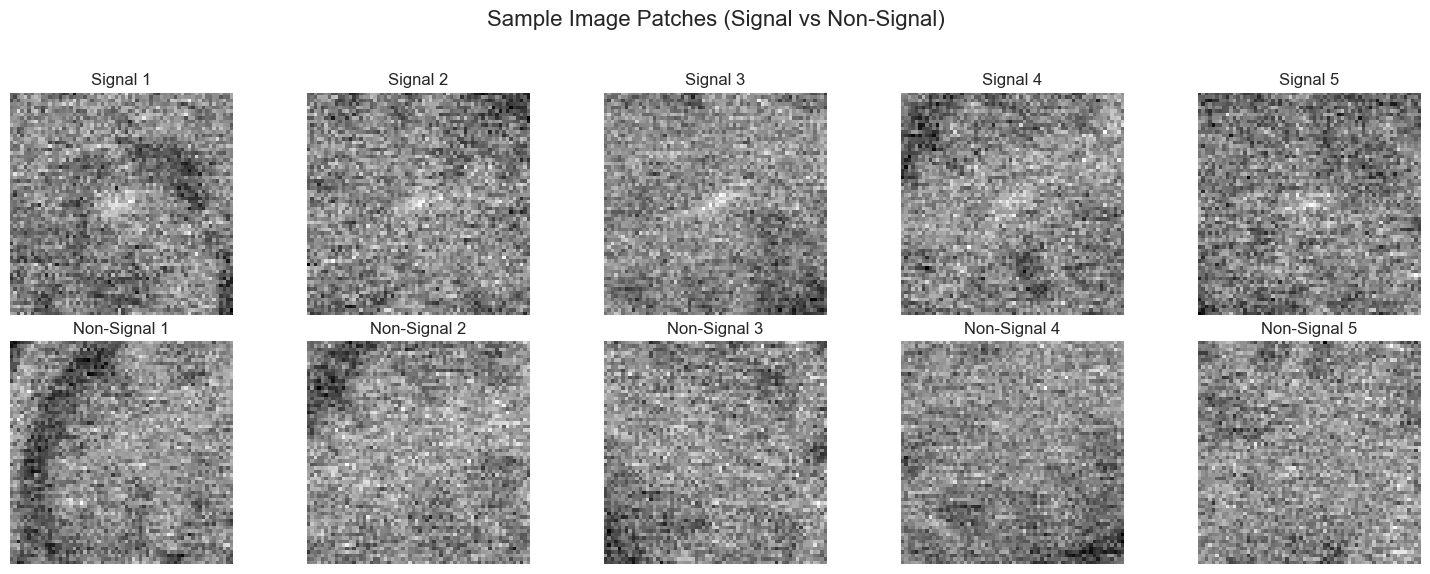

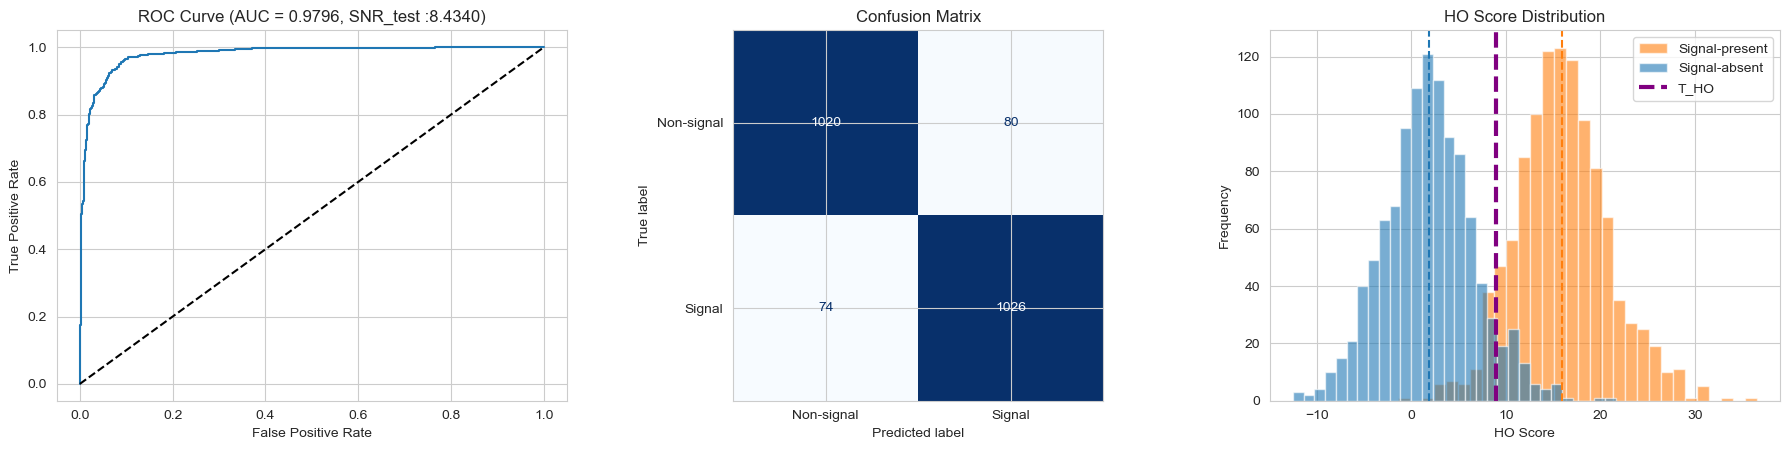

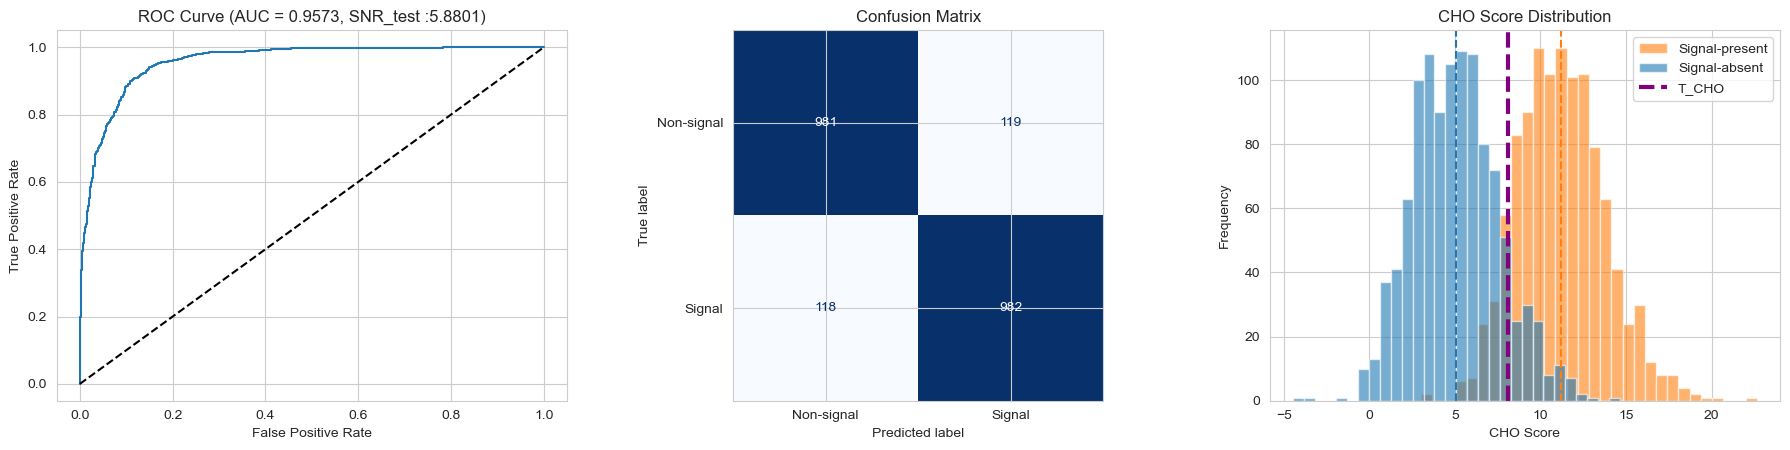


=== Showing results for: patches_amp_0.2_noise_0.004_accel_4.npy ===


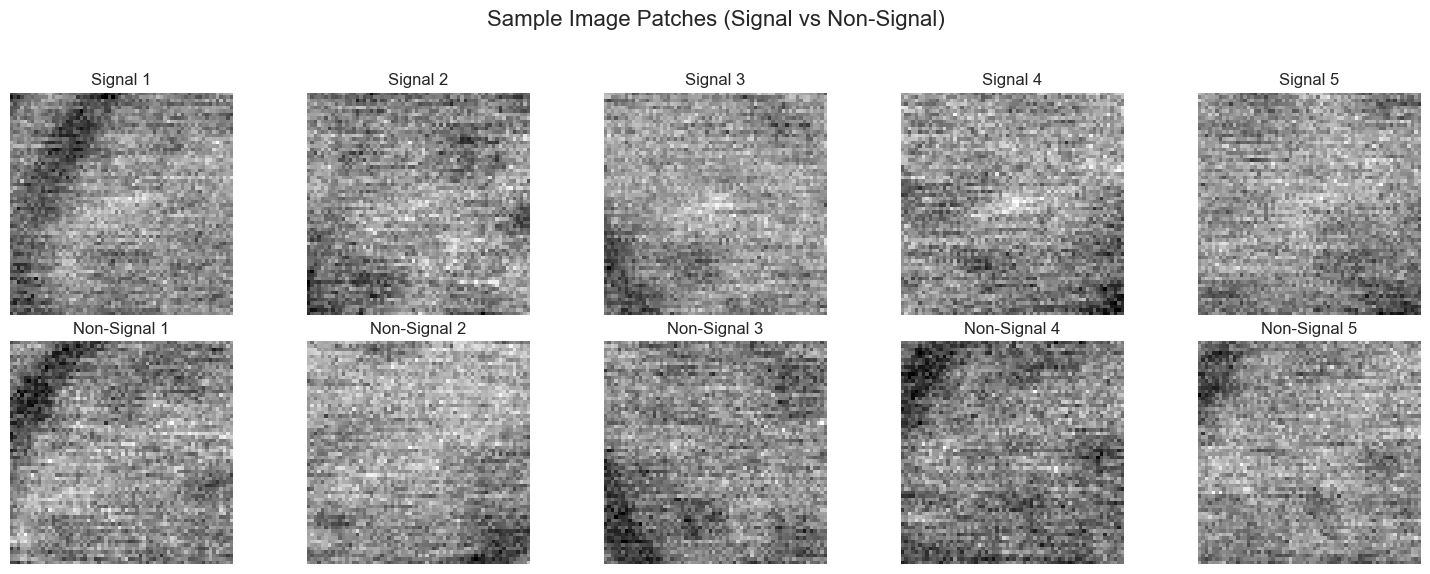

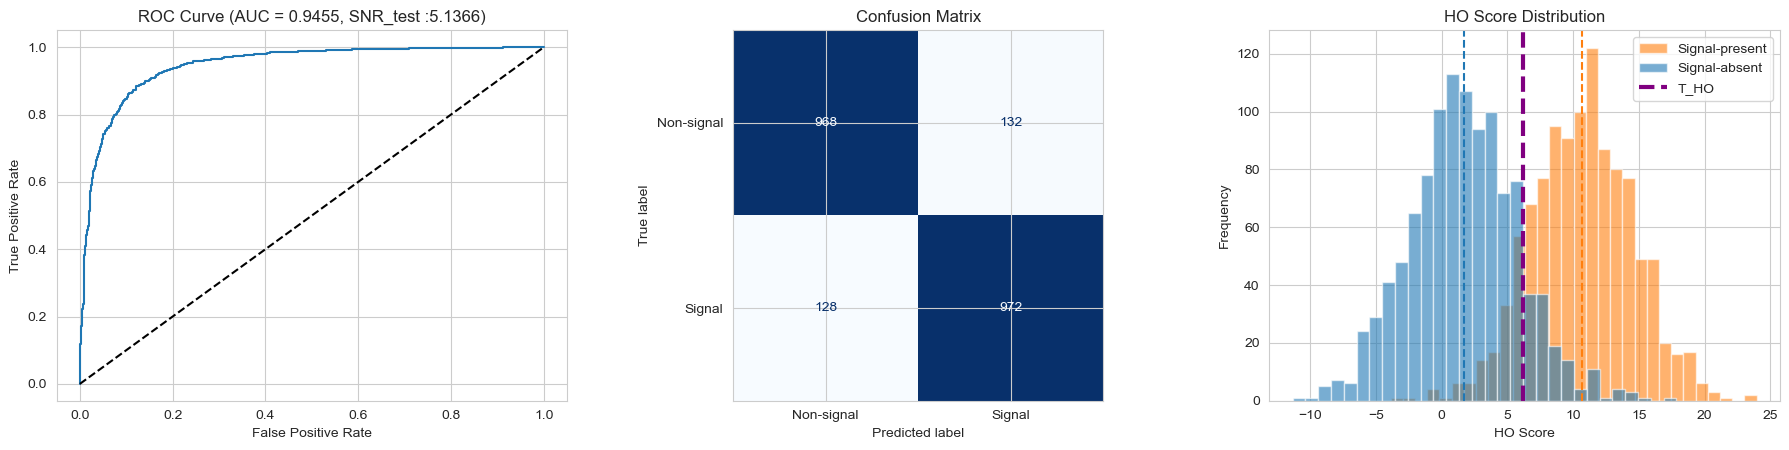

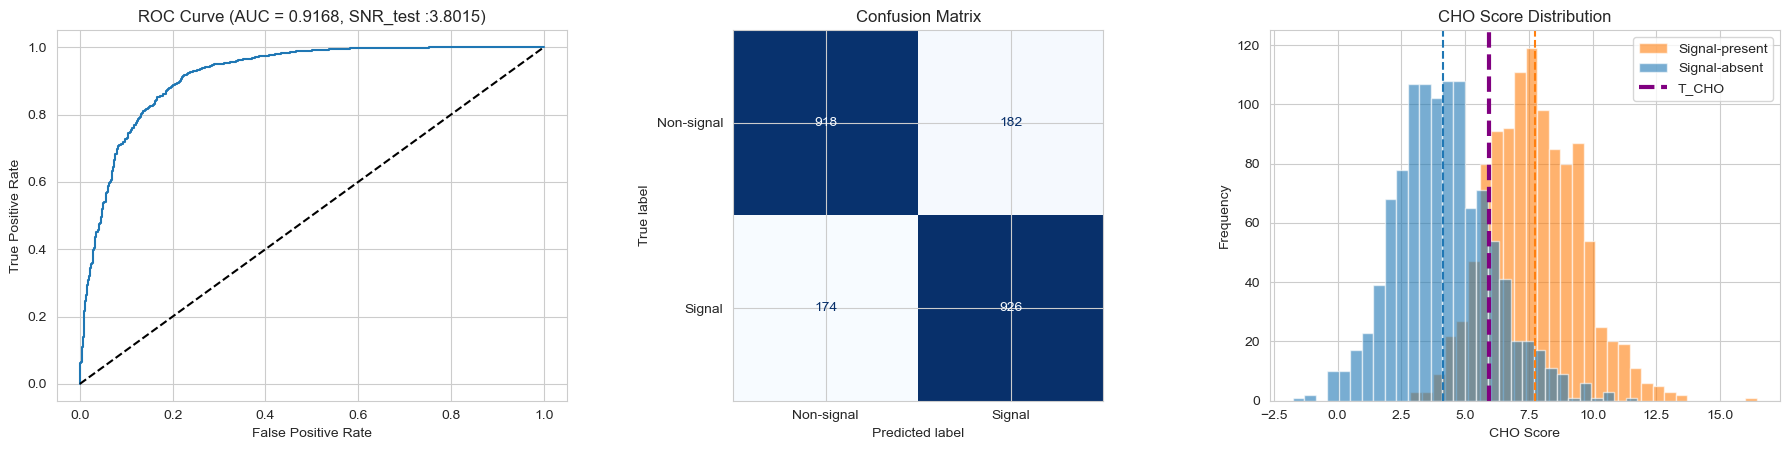


=== Showing results for: patches_amp_0.2_noise_0.008_accel_2.npy ===


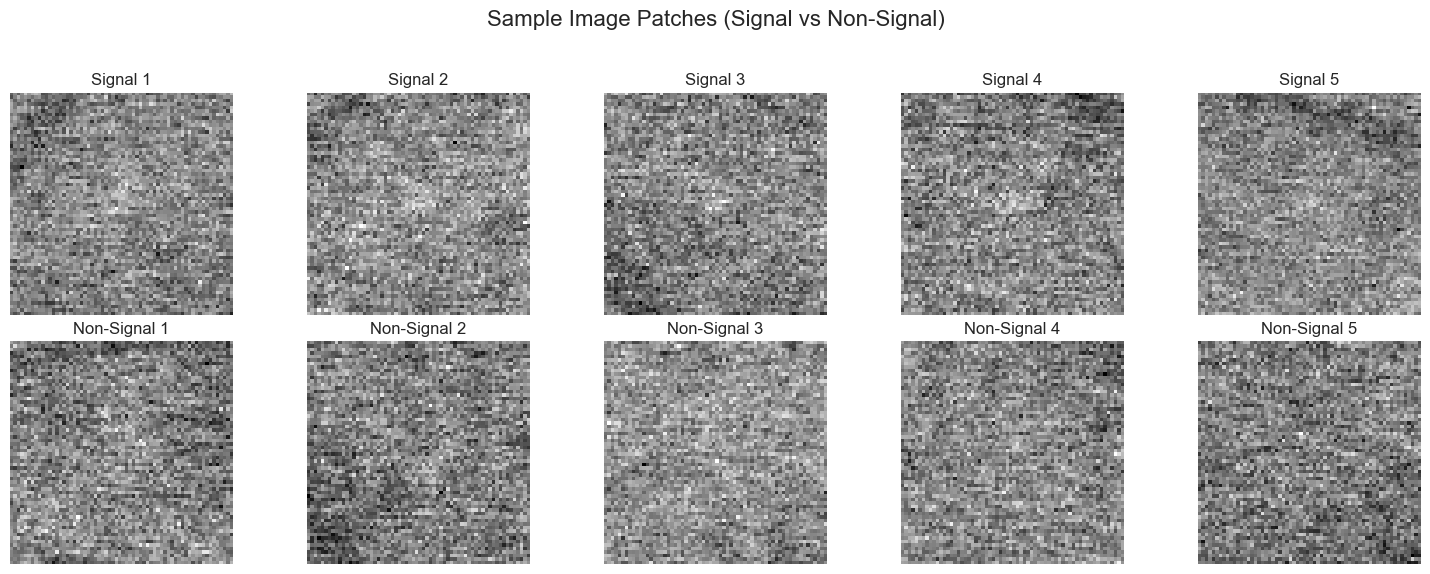

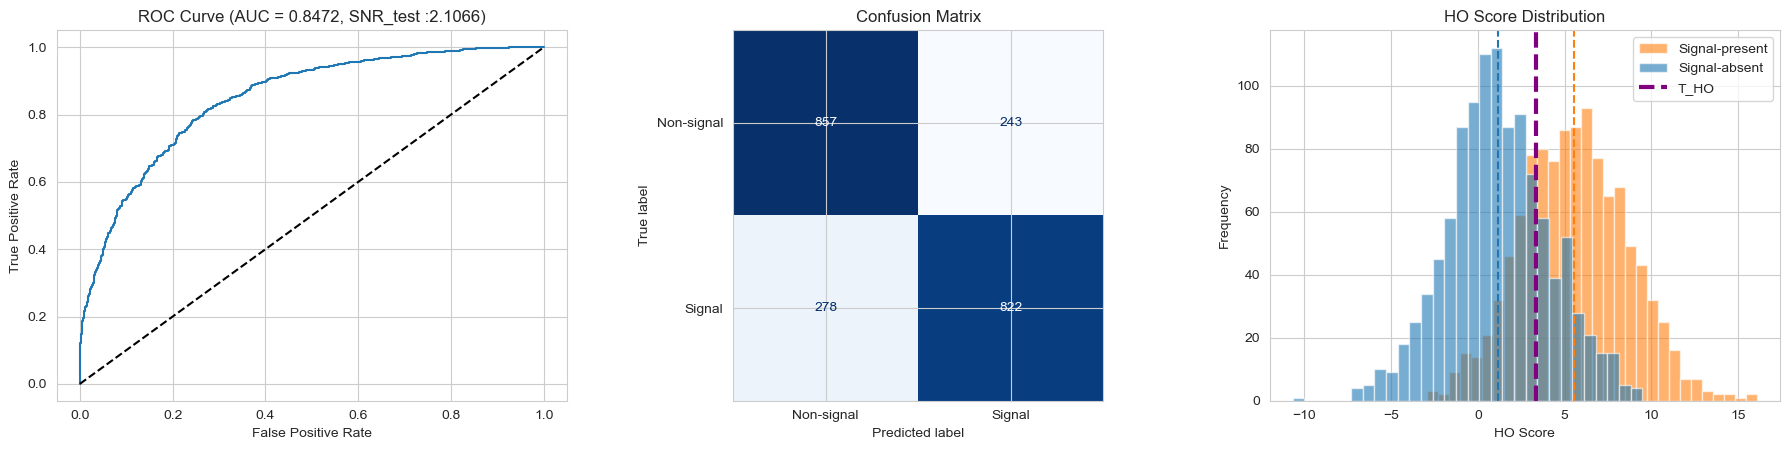

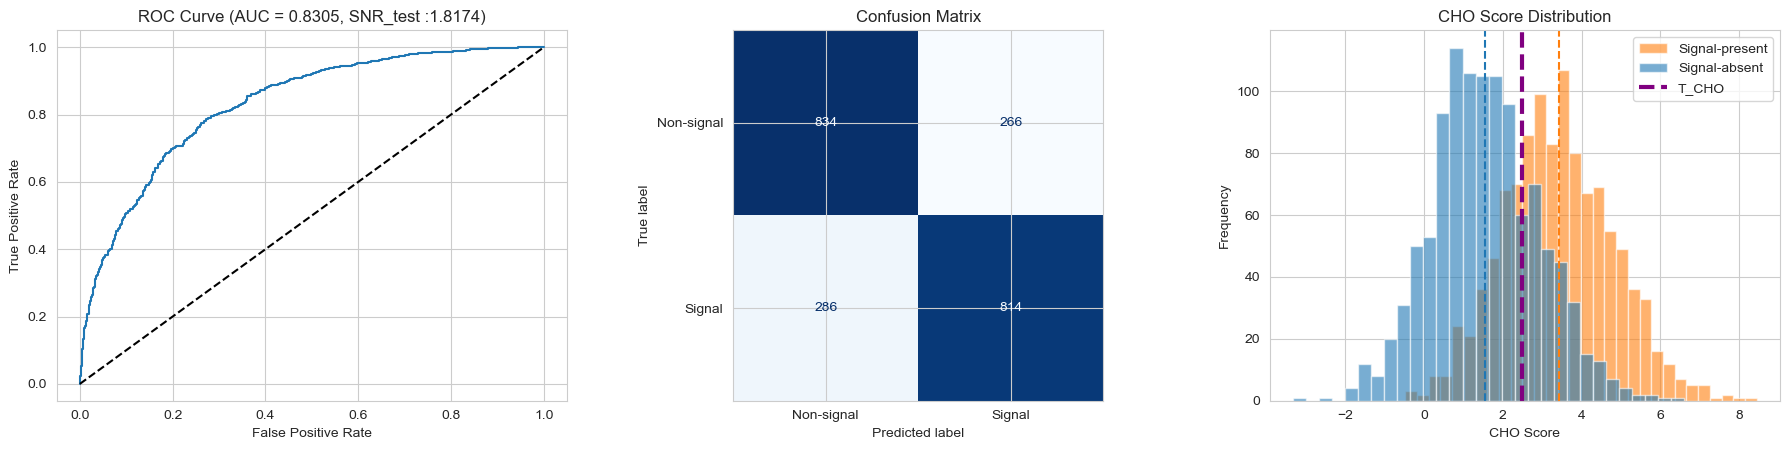


=== Showing results for: patches_amp_0.2_noise_0.008_accel_4.npy ===


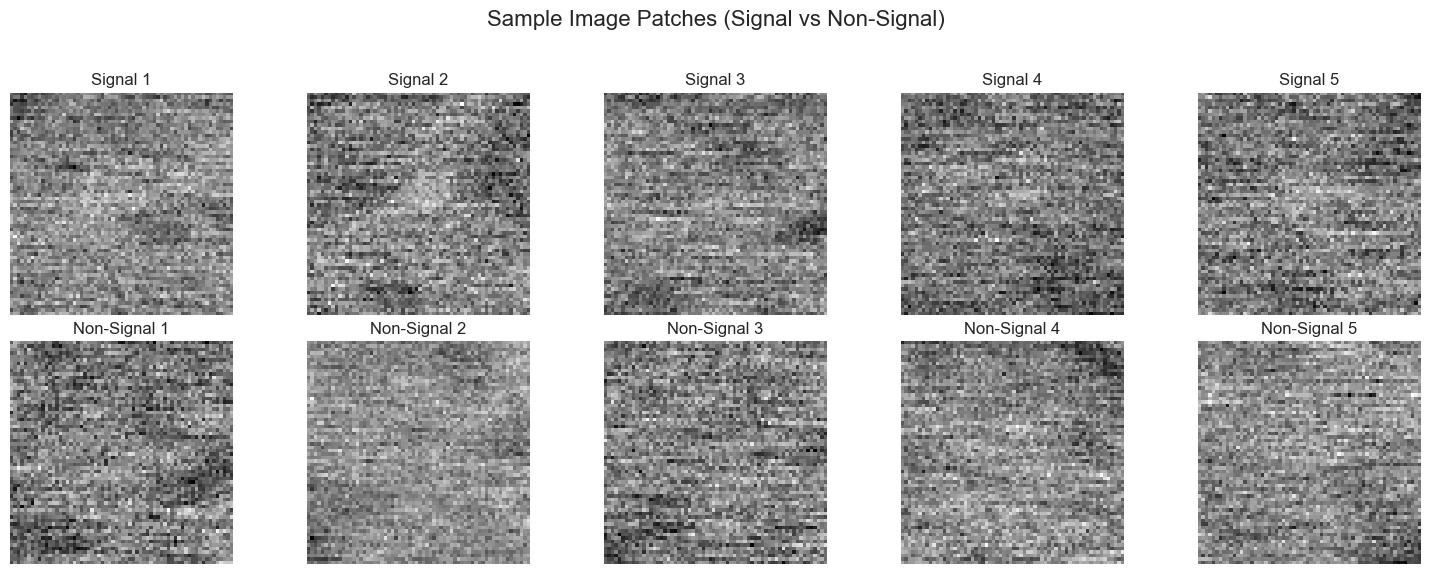

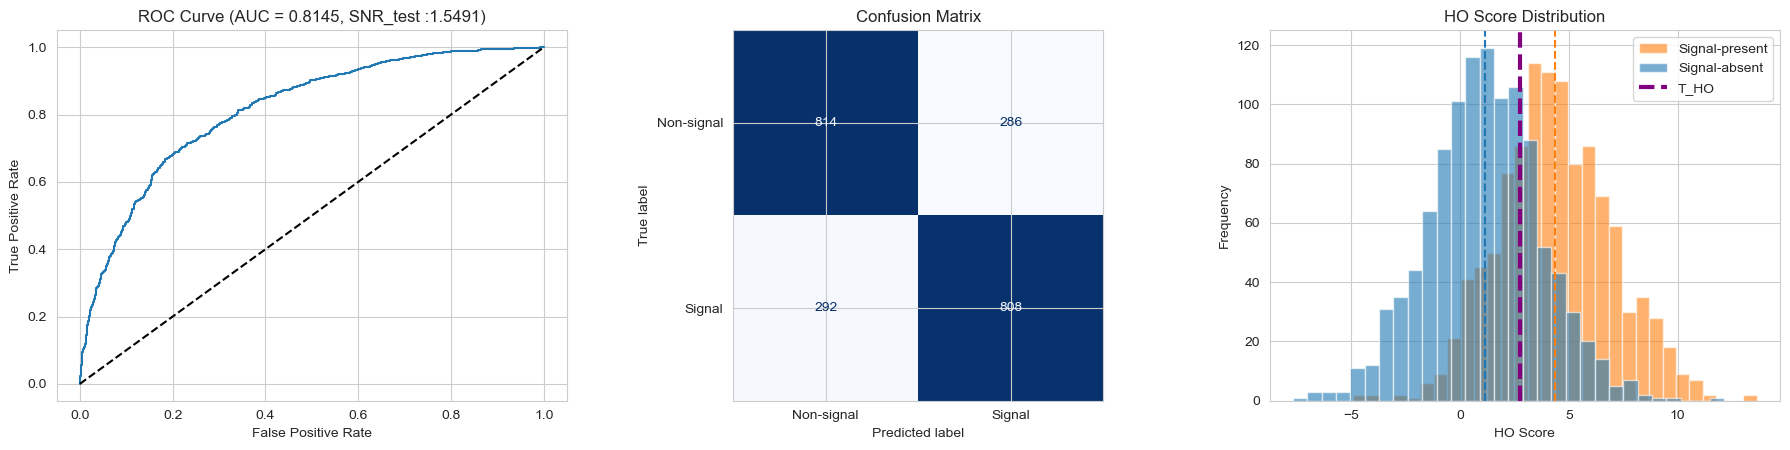

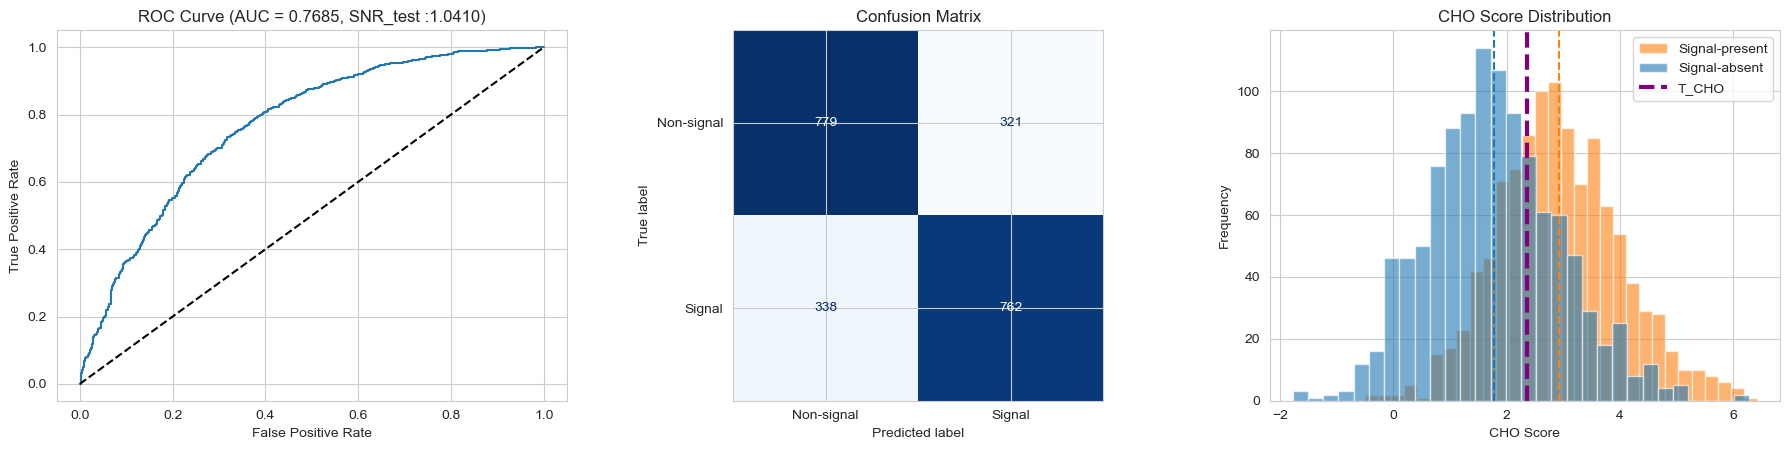

In [2]:
summary_data = []

npy_files = list(Path("./Ready_to_train").glob("*.npy"))

for npy_file in npy_files:
    print(f"\n=== Showing results for: {npy_file.name} ===")

    # 1. Load the data
    img = np.load(npy_file, allow_pickle=True).item()
    signal_patches = img['signal_patches']
    nonsignal_patches = img['nonsignal_patches']
    ref_patches = img['reference_patches']

    # 2. Display sample patches
    display_sample_patches(signal_patches, nonsignal_patches)

    # 3. Traditional metrics: MSE & SSIM
    mse_list = [np.mean((a - b) ** 2) for a, b in zip(nonsignal_patches, ref_patches)]
    mse = np.mean(mse_list)
    ssim_list = [ssim(a, b, data_range=1.0) for a, b in zip(nonsignal_patches, ref_patches)]
    ssim_val = np.mean(ssim_list)

    # 4. Flatten and label
    X_signal = np.array([p.flatten() for p in signal_patches])
    X_nonsignal = np.array([p.flatten() for p in nonsignal_patches])
    X = np.vstack([X_signal, X_nonsignal])
    y = np.array([1] * len(X_signal) + [0] * len(X_nonsignal))

    # 5. Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=42)

    # ===== Standard Hotelling Observer =====
    w_ho = train_HO(X_train, y_train)
    t_ho_score_train = apply_HO(X_train, w_ho)
    t_ho_score_test = apply_HO(X_test, w_ho)
    t_test_ho = compute_decision_threshold(t_ho_score_test, y_test)
    SNR_ho_test = compute_SNR_squared(t_ho_score_test, y_test)
    # Compute ROC curve and AUC for HO
    FPF_ho, TPF_ho, _ = roc_curve(y_test, t_ho_score_test)
    AUC_ho = roc_auc_score(y_test, t_ho_score_test)
    # Compute confusion matrix fo HO
    y_pred_ho = (t_ho_score_test > t_test_ho).astype(int)
    cm_ho = confusion_matrix(y_test, y_pred_ho)

    # ===== Channelized Hotelling Observer =====
    U = generate_gabor_U() # Creation of the channelized U
    v_train = X_train @ U
    v_test = X_test @ U
    w_cho = train_HO(v_train, y_train)
    t_cho_score_test = apply_HO(v_test, w_cho)
    t_test_cho = compute_decision_threshold(t_cho_score_test, y_test)
    SNR_cho_test = compute_SNR_squared(t_cho_score_test, y_test)
    # Compute ROC curve and AUC for CHO
    FPF_cho, TPF_cho, _ = roc_curve(y_test, t_cho_score_test)
    AUC_cho = roc_auc_score(y_test, t_cho_score_test)
    # Compute confusion matrix fo CHO
    y_pred_cho = (t_cho_score_test > t_test_cho).astype(int)
    cm_cho = confusion_matrix(y_test, y_pred_cho)


    # ===== Channelized Hotelling Observer =====

    fig, axs = plt.subplots(1, 3, figsize=(18, 5))

    # ROC
    axs[0].plot(FPF_ho, TPF_ho)
    axs[0].plot([0, 1], [0, 1], 'k--')
    axs[0].set_title(f'ROC Curve (AUC = {AUC_ho:.4f}, SNR_test :{SNR_ho_test:.4f})')
    axs[0].set_xlabel('False Positive Rate')
    axs[0].set_ylabel('True Positive Rate')
    axs[0].grid(True)

    # Confusion Matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_ho, display_labels=["Non-signal", "Signal"])
    disp.plot(ax=axs[1], cmap=plt.cm.Blues, colorbar=False)
    axs[1].set_title('Confusion Matrix')

    # HO Score Distribution
    axs[2].hist(t_ho_score_test[y_test == 1], bins=30, alpha=0.6, label='Signal-present', color='C1')
    axs[2].hist(t_ho_score_test[y_test == 0], bins=30, alpha=0.6, label='Signal-absent', color='C0')
    axs[2].axvline(np.mean(t_ho_score_test[y_test == 1]), color='C1', linestyle='--')
    axs[2].axvline(np.mean(t_ho_score_test[y_test == 0]), color='C0', linestyle='--')
    axs[2].axvline(t_test_ho, color='purple', linestyle='--', linewidth=3, label='T_HO')
    axs[2].set_title('HO Score Distribution')
    axs[2].set_xlabel('HO Score')
    axs[2].set_ylabel('Frequency')
    axs[2].legend()
    axs[2].grid(True)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    # ===== Channelized Hotelling Observer =====

    fig, axs = plt.subplots(1, 3, figsize=(18, 5))

    # ROC
    axs[0].plot(FPF_cho, TPF_cho)
    axs[0].plot([0, 1], [0, 1], 'k--')
    axs[0].set_title(f'ROC Curve (AUC = {AUC_cho:.4f}, SNR_test :{SNR_cho_test:.4f})')
    axs[0].set_xlabel('False Positive Rate')
    axs[0].set_ylabel('True Positive Rate')
    axs[0].grid(True)

    # Confusion Matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_cho, display_labels=["Non-signal", "Signal"])
    disp.plot(ax=axs[1], cmap=plt.cm.Blues, colorbar=False)
    axs[1].set_title('Confusion Matrix')

    # HO Score Distribution
    axs[2].hist(t_cho_score_test[y_test == 1], bins=30, alpha=0.6, label='Signal-present', color='C1')
    axs[2].hist(t_cho_score_test[y_test == 0], bins=30, alpha=0.6, label='Signal-absent', color='C0')
    axs[2].axvline(np.mean(t_cho_score_test[y_test == 1]), color='C1', linestyle='--')
    axs[2].axvline(np.mean(t_cho_score_test[y_test == 0]), color='C0', linestyle='--')
    axs[2].axvline(t_test_cho, color='purple', linestyle='--', linewidth=3, label='T_CHO')
    axs[2].set_title('CHO Score Distribution')
    axs[2].set_xlabel('CHO Score')
    axs[2].set_ylabel('Frequency')
    axs[2].legend()
    axs[2].grid(True)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    # Save results
    summary_data.append({
        'Filename': npy_file.name,
        'MSE': mse,
        'SSIM': ssim_val,
        'SNR_HO': SNR_ho_test,
        'SNR_CHO': SNR_cho_test,
        'AUC_HO': AUC_ho,
        'AUC_CHO': AUC_cho
    })

In [3]:
import pandas as pd

df = pd.DataFrame(summary_data)

# Clean 'Filename' column
df['Filename'] = df['Filename'].str.replace('patches_', '', regex=False)
df['Filename'] = df['Filename'].str.replace('.npy', '', regex=False)

# Drop SNR_HO and SNR_CHO columns
df = df.drop(columns=['SNR_HO', 'SNR_CHO'])

# Sort by filename
df_sorted = df.sort_values(by='Filename')

# Show the full table without it splitting
with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.width', 1000):
    print(df_sorted)


                         Filename       MSE      SSIM    AUC_HO   AUC_CHO
0   amp_0.05_noise_0.0001_accel_2  0.000754  0.831374  0.970720  0.933610
1   amp_0.05_noise_0.0001_accel_4  0.002292  0.671647  0.881902  0.806439
2   amp_0.05_noise_0.0004_accel_2  0.001039  0.771427  0.949415  0.902210
3   amp_0.05_noise_0.0004_accel_4  0.002427  0.645395  0.845517  0.790953
4    amp_0.05_noise_0.001_accel_2  0.002610  0.577274  0.889293  0.833364
5    amp_0.05_noise_0.001_accel_4  0.003231  0.536771  0.779436  0.753499
6    amp_0.05_noise_0.004_accel_2  0.030694  0.142117  0.637862  0.667107
7    amp_0.05_noise_0.004_accel_4  0.017452  0.171627  0.579845  0.615850
8    amp_0.05_noise_0.008_accel_2  0.120554  0.044458  0.541124  0.586913
9    amp_0.05_noise_0.008_accel_4  0.062948  0.059680  0.566979  0.565111
10   amp_0.2_noise_0.0001_accel_2  0.000755  0.831208  0.999999  0.999833
11   amp_0.2_noise_0.0001_accel_4  0.002292  0.671645  0.999960  0.999689
12   amp_0.2_noise_0.0004_accel_2  0.0

In [4]:
import pandas as pd

# Assume df_sorted is already loaded
df_sorted = df.copy()  # Replace with your actual DataFrame if needed

# ✅ Keep only numeric columns
numeric_df = df_sorted.select_dtypes(include='number')

# Compute Pearson and Spearman correlation matrices (both)
pearson_corr = numeric_df.corr(method='pearson')
spearman_corr = numeric_df.corr(method='spearman')  # calculated but not shown

# Helper function to classify strength
def classify_strength(value):
    abs_val = abs(value)
    if abs_val >= 0.9:
        return 'Very strong'
    elif abs_val >= 0.7:
        return 'Strong'
    elif abs_val >= 0.5:
        return 'Moderate'
    elif abs_val >= 0.3:
        return 'Weak'
    else:
        return 'Very weak'

# List of metric columns
metrics = numeric_df.columns.tolist()

# Collect rows in a list
rows = []

for i in range(len(metrics)):
    for j in range(i + 1, len(metrics)):
        pair = f"{metrics[i]} vs {metrics[j]}"
        pearson_value = pearson_corr.loc[metrics[i], metrics[j]]
        # Spearman is computed but not shown
        _ = spearman_corr.loc[metrics[i], metrics[j]]
        direction = 'Positive' if pearson_value >= 0 else 'Negative'
        strength = classify_strength(pearson_value)

        rows.append({
            'Metric Pair': pair,
            'Pearson Correlation': pearson_value,
            'Direction': direction,
            'Strength': strength
        })

# Create summary DataFrame
summary_table = pd.DataFrame(rows)

# Show the table
print(summary_table)


         Metric Pair  Pearson Correlation Direction     Strength
0        MSE vs SSIM            -0.779176  Negative       Strong
1      MSE vs AUC_HO            -0.577032  Negative     Moderate
2     MSE vs AUC_CHO            -0.549210  Negative     Moderate
3     SSIM vs AUC_HO             0.671230  Positive     Moderate
4    SSIM vs AUC_CHO             0.644061  Positive     Moderate
5  AUC_HO vs AUC_CHO             0.981076  Positive  Very strong
